In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost, shap, pickle, warnings

from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import log_loss, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')
brown_colors = ["#3c291f", "#FF0000"]
r, g, b = 60 / 255, 41 / 255, 31 / 255
Browns = LinearSegmentedColormap(
    'Browns', {
        'red': ((0, 1, 1), (1, r, r)),
        'green': ((0, 1, 1), (1, g, g)),
        'blue': ((0, 1, 1), (1, b, b))
    })

sns.set_theme(style="ticks",
              palette="pastel",
              font_scale=1.8,
              rc={
                  'figure.figsize': (12, 8),
                  'axes.titlesize': 20,
                  'axes.labelsize': 20,
                  'xtick.labelsize': 18,
                  'ytick.labelsize': 18,
                  'legend.fontsize': 14
              })

df = pd.read_csv('../data/processed_dataset.csv')
div = lambda s: print('-' * 50 + '\n' + str(s))

In [2]:
def MLpipe_KFold_Logloss(model,
                         param_grid,
                         random_state=None,
                         repeat=10,
                         n_splits=4,
                         train_size=0.8):

    X, y = df.drop(['Type'], axis=1), df['Type']
    cat_ftrs, num_ftrs = df.columns[:4], df.columns[4:-1]

    rng = np.random.RandomState(random_state)
    results = np.empty(repeat, dtype=object)
    scores = {
        'val': np.empty(repeat, dtype=np.float64),
        'baseline': {
            'log_loss': np.empty(repeat, dtype=np.float64),
            'f2.0': np.empty(repeat, dtype=np.float64),
            'f0.5': np.empty(repeat, dtype=np.float64)
        },
        'test': {
            'log_loss': np.empty(repeat, dtype=np.float64),
            'f2.0': np.empty(repeat, dtype=np.float64),
            'f0.5': np.empty(repeat, dtype=np.float64),
            'cm': np.empty(repeat, dtype=object)
        }
    }

    # CV Log
    l_other = int(len(X) * train_size)
    n_higher_count = l_other % n_splits
    lower_count = l_other // n_splits
    print(
        f'CV splits: {[lower_count + 1] * n_higher_count + [lower_count] * (n_splits - n_higher_count)}\n'
    )

    for i in range(repeat):
        save_name = f'../results/results_{model.__class__.__name__}_{i}.pkl'
        seed = rng.randint(1000)
        X_other, X_test, y_other, y_test = train_test_split(
                X, y, train_size=train_size, random_state=seed)
        # if model exist in file
        try:
            with open(save_name, 'rb') as f:
                grid, *_ = pickle.load(f)
                print('Loaded model', save_name)
        except FileNotFoundError:
            print(f'Iteration {i}, Random_state: {seed}')
            print(f'X_other: {X_other.shape}, X_test: {X_test.shape}, '
                  f'y_other: {y_other.shape},  y_test: {y_test.shape}')

            preprocessor = ColumnTransformer([
                ('num',
                 Pipeline([('iterative_imputer',
                            IterativeImputer(random_state=seed)),
                           ('scaler', StandardScaler())]), num_ftrs),
                ('cat',
                 Pipeline([('imputer',
                            SimpleImputer(strategy='constant',
                                          fill_value='MISSING')),
                           ('onehot',
                            OneHotEncoder(sparse=False,
                                          handle_unknown='ignore'))]),
                 cat_ftrs)
            ])

            # Construct pipeline
            pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])

            # Inject random state to model
            try:
                pipe.set_params(model__random_state=seed)
            except ValueError:
                pass

            # Run GridSearchCV
            kcv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
            grid = GridSearchCV(pipe,
                                param_grid,
                                cv=kcv,
                                scoring='neg_log_loss',
                                n_jobs=-1)
            grid.fit(X_other, y_other)
            with open(save_name, 'wb') as f:
                pickle.dump((grid, X_test, y_test), f)
        results[i] = grid.best_params_
        scores['val'][i] = -grid.best_score_

        print(f'CValidation log loss: \t{scores["val"][i]:.07f}')
        # Baseline
        all_pos = np.ones_like(y_test)
        all_neg = np.zeros_like(y_test)

        scores['baseline']['log_loss'][i] = min(
            log_loss(y_test, all_neg), log_loss(y_test, all_pos),
            log_loss(y_test, all_pos * y_other.mean()))
        scores['baseline']['f2.0'][i] = max(
            fbeta_score(y_test, all_neg, beta=2.0),
            fbeta_score(y_test, all_pos, beta=2.0))

        scores['baseline']['f0.5'][i] = max(
            fbeta_score(y_test, all_neg, beta=0.5),
            fbeta_score(y_test, all_pos, beta=0.5))
        # Manual metrics
        y_pred = grid.best_estimator_.predict(X_test)
        with open(f'../results/pred_{model.__class__.__name__}_{i}.pkl',
                  'wb') as f:
            pickle.dump(y_pred, f)
        scores['test']['log_loss'][i] = log_loss(
            y_test, grid.best_estimator_.predict_proba(X_test))
        scores['test']['f2.0'][i] = fbeta_score(y_test, y_pred, beta=2.0)
        scores['test']['f0.5'][i] = fbeta_score(y_test, y_pred, beta=0.5)
        scores['test']['cm'][i] = confusion_matrix(y_test, y_pred)
        print(f"Test log loss: \t\t{scores['test']['log_loss'][i]:.07f}\n")
    return results, scores


In [3]:
def basic_split(X, y, train_size, val_size, test_size, random_state):
    val_ratio = val_size / (test_size + val_size)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    train_size=val_ratio,
                                                    random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test


def preprocess(df, random_state=None):
    cat_ftrs, num_ftrs = df.columns[:4], df.columns[4:-1]
    preprocessor = ColumnTransformer([
        ('num',
         Pipeline([('iterative_imputer',
                    IterativeImputer(random_state=random_state)),
                   ('scaler', StandardScaler())]), num_ftrs),
        ('cat',
         Pipeline([('imputer',
                    SimpleImputer(strategy='constant', fill_value='MISSING')),
                   ('onehot',
                    OneHotEncoder(sparse=False,
                                  handle_unknown='ignore'))]), cat_ftrs)
    ])

    X_train, y_train, X_val, y_val, X_test, y_test = basic_split(
        df.drop('Type', axis=1), df['Type'], 0.8, 0.1, 0.1, random_state)

    X_train = preprocessor.fit_transform(X_train)
    feature_names = preprocessor.get_feature_names_out()

    X_val = preprocessor.transform(X_val)
    X_test = preprocessor.transform(X_test)

    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_val = pd.DataFrame(X_val, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)
    return X_train, y_train, X_val, y_val, X_test, y_test


def xgb_tune(df, param_grid, random_state, repeat=5):
    rng = np.random.RandomState(random_state)
    results = np.empty(repeat, dtype=object)
    scores = {
        'val': np.full(repeat, np.inf, dtype=np.float64),
        'baseline': {
            'log_loss': np.empty(repeat, dtype=np.float64),
            'f2.0': np.empty(repeat, dtype=np.float64),
            'f0.5': np.empty(repeat, dtype=np.float64)
        },
        'test': {
            'log_loss': np.empty(repeat, dtype=np.float64),
            'f2.0': np.empty(repeat, dtype=np.float64),
            'f0.5': np.empty(repeat, dtype=np.float64),
            'cm': np.empty(repeat, dtype=object)
        }
    }

    for i in range(repeat):
        seed = rng.randint(1000)
        save_name = f'../results/results_XGBoost_{i}.pkl'
        X_train, y_train, X_val, y_val, X_test, y_test = preprocess(df, seed)
        try:
            with open(save_name, 'rb') as f:
                best_model, *_ = pickle.load(f)
                print('Loaded model', save_name)
        except FileNotFoundError:
            print(f'Iteration {i}, Random_state: {seed}')
            print(
                f'X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape} '
                f'y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}'
            )
            for p in param_grid:
                model = xgboost.XGBClassifier(eta=0.05,
                                              seed=seed,
                                              eval_metric='logloss',
                                              n_jobs=-1,
                                              early_stopping_rounds=20,
                                              **p)
                model.fit(X_train,
                          y_train,
                          eval_set=[(X_val, y_val)],
                          verbose=False)
                val_score = log_loss(y_val, model.predict(X_val))
                if val_score < scores['val'][i]:
                    results[i] = p
                    scores['val'][i] = val_score
                    best_model = model
            with open(save_name, 'wb') as f:
                pickle.dump((best_model, X_test, y_test), f)
        all_pos = np.ones_like(y_test)
        all_neg = np.zeros_like(y_test)

        scores['baseline']['log_loss'][i] = min(
            log_loss(y_test, all_neg), log_loss(y_test, all_pos),
            log_loss(y_test, all_pos * y_train.mean()))
        scores['baseline']['f2.0'][i] = max(
            fbeta_score(y_test, all_neg, beta=2.0),
            fbeta_score(y_test, all_pos, beta=2.0))

        scores['baseline']['f0.5'][i] = max(
            fbeta_score(y_test, all_neg, beta=0.5),
            fbeta_score(y_test, all_pos, beta=0.5))

        y_pred = best_model.predict(X_test)
        with open(f'../results/pred_XGBoost_{i}.pkl', 'wb') as f:
            pickle.dump(y_pred, f)
        scores['test']['log_loss'][i] = log_loss(
            y_test, best_model.predict_proba(X_test))
        scores['test']['f2.0'][i] = fbeta_score(y_test, y_pred, beta=2.0)
        scores['test']['f0.5'][i] = fbeta_score(y_test, y_pred, beta=0.5)
        scores['test']['cm'][i] = confusion_matrix(y_test, y_pred)
        print(f'Validation log loss: \t{scores["val"][i]:.07f}')
        print(f"Test log loss: \t\t{scores['test']['log_loss'][i]:.07f}\n")
    return results, scores

In [4]:
n_repeat = 5
SEED = 42

div('Logistic Regression')
model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)
params = {
    'model__C': np.logspace(-4, 4, 5),
    'model__l1_ratio': np.linspace(0, 1, 5)
}
log_results, log_scores = MLpipe_KFold_Logloss(model,
                                              params,
                                              SEED,
                                              repeat=n_repeat)

div('SVC')
model = SVC(probability=True)
params = {
    'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'model__degree': np.arange(1, 5)
}
svc_results, svc_scores = MLpipe_KFold_Logloss(model,
                                              params,
                                              SEED,
                                              repeat=n_repeat)

div('KNN')
model = KNeighborsClassifier()
params = {
    'model__n_neighbors': np.arange(5, 55, 10),
    'model__weights': ['uniform', 'distance'],
}
knn_results, knn_scores = MLpipe_KFold_Logloss(model,
                                              params,
                                              SEED,
                                              repeat=n_repeat)

div('Random Forest')
model = RandomForestClassifier()
params = {
    'model__n_estimators': [100, 500, 1000],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
}
rf_results, rf_scores = MLpipe_KFold_Logloss(model,
                                            params,
                                            SEED,
                                            repeat=n_repeat)

div('XGBoost')
params = ParameterGrid({
    "n_estimators": [1000, 10000],
    "reg_alpha": np.linspace(0, 1000, 3),
    "reg_lambda": np.logspace(0, 3, 3),
    "max_depth": [6, 8, 10],
    "subsample": [0.33, 0.66, 0.99]
})
xgb_results, xgb_scores = xgb_tune(df, params, SEED, repeat=n_repeat)

--------------------------------------------------
Logistic Regression
CV splits: [356, 356, 356, 356]

Loaded model ../results/results_LogisticRegression_0.pkl
CValidation log loss: 	0.1622046
Test log loss: 		0.1770137

Loaded model ../results/results_LogisticRegression_1.pkl
CValidation log loss: 	0.1570788
Test log loss: 		0.1720222

Loaded model ../results/results_LogisticRegression_2.pkl
CValidation log loss: 	0.1548984
Test log loss: 		0.1376486

Loaded model ../results/results_LogisticRegression_3.pkl
CValidation log loss: 	0.1622905
Test log loss: 		0.1301350

Loaded model ../results/results_LogisticRegression_4.pkl
CValidation log loss: 	0.1857473
Test log loss: 		0.1390884

--------------------------------------------------
SVC
CV splits: [356, 356, 356, 356]

Loaded model ../results/results_SVC_0.pkl
CValidation log loss: 	0.1409094
Test log loss: 		0.1403585

Loaded model ../results/results_SVC_1.pkl
CValidation log loss: 	0.1366117
Test log loss: 		0.1652040

Loaded model

--------------------------------------------------
log_loss
Log       -10.531904
SVC       -11.497160
KNN        -5.989793
RF        -13.293821
XGBoost    -5.212581
dtype: float64
--------------------------------------------------
f2.0
Log        12.740688
SVC         9.595579
KNN        13.109733
RF         15.502773
XGBoost     6.641090
dtype: float64
--------------------------------------------------
f0.5
Log        54.778821
SVC        60.116398
KNN        46.786777
RF         65.383454
XGBoost    23.601336
dtype: float64


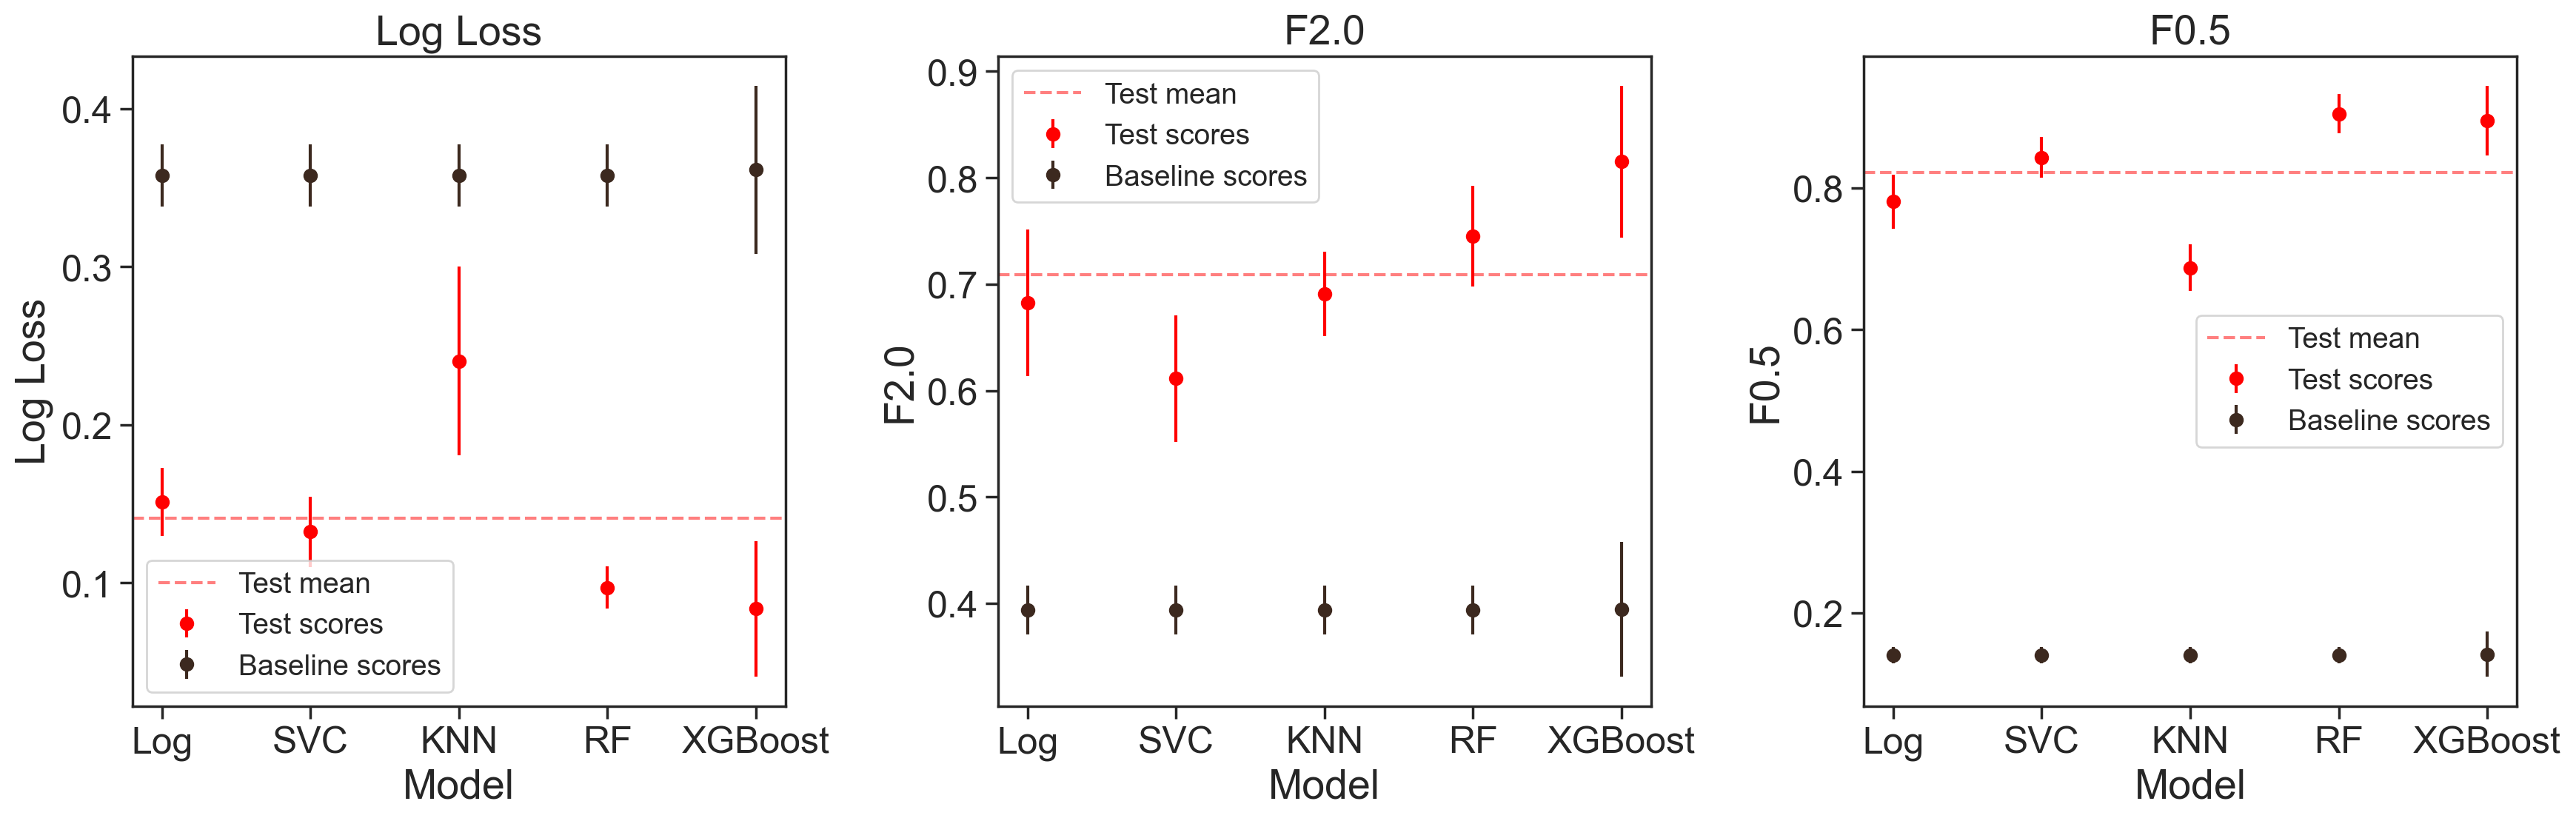

In [5]:
score_labels = ['log_loss', 'f2.0', 'f0.5']
score_names = ['Log Loss', 'F2.0', 'F0.5']
scores = [log_scores, svc_scores, knn_scores, rf_scores, xgb_scores]
models = ['Log', 'SVC', 'KNN', 'RF', 'XGBoost']

n_models = len(models)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, score in enumerate(score_labels):
    baseline_scores_df = pd.DataFrame(
        dict(zip(models, [_['baseline'][score] for _ in scores])))
    test_scores_df = pd.DataFrame(
        dict(zip(models, [_['test'][score] for _ in scores])))

    std_dist = (test_scores_df.mean() -
                baseline_scores_df.mean()) / baseline_scores_df.std()
    div(score)
    print(std_dist)

    ax[i].errorbar(range(n_models),
                   test_scores_df.mean(),
                   yerr=test_scores_df.std(),
                   fmt='o',
                   label='Test scores',
                   c=brown_colors[1])

    ax[i].errorbar(range(n_models),
                   baseline_scores_df.mean(),
                   yerr=baseline_scores_df.std(),
                   fmt='o',
                   label='Baseline scores',
                   c=brown_colors[0])
    ax[i].axhline(test_scores_df.mean().mean(),
                  color='r',
                  linestyle='--',
                  label='Test mean',
                  c=brown_colors[1],
                  alpha=0.5)
    ax[i].set_xticks(range(n_models), test_scores_df.columns)
    ax[i].set(xlabel='Model', ylabel=score_names[i], title=score_names[i])
    ax[i].legend()
fig.tight_layout()
fig.savefig('../figures/Results.png', dpi=400)
fig.savefig('../figures/Results.pdf', dpi=400)

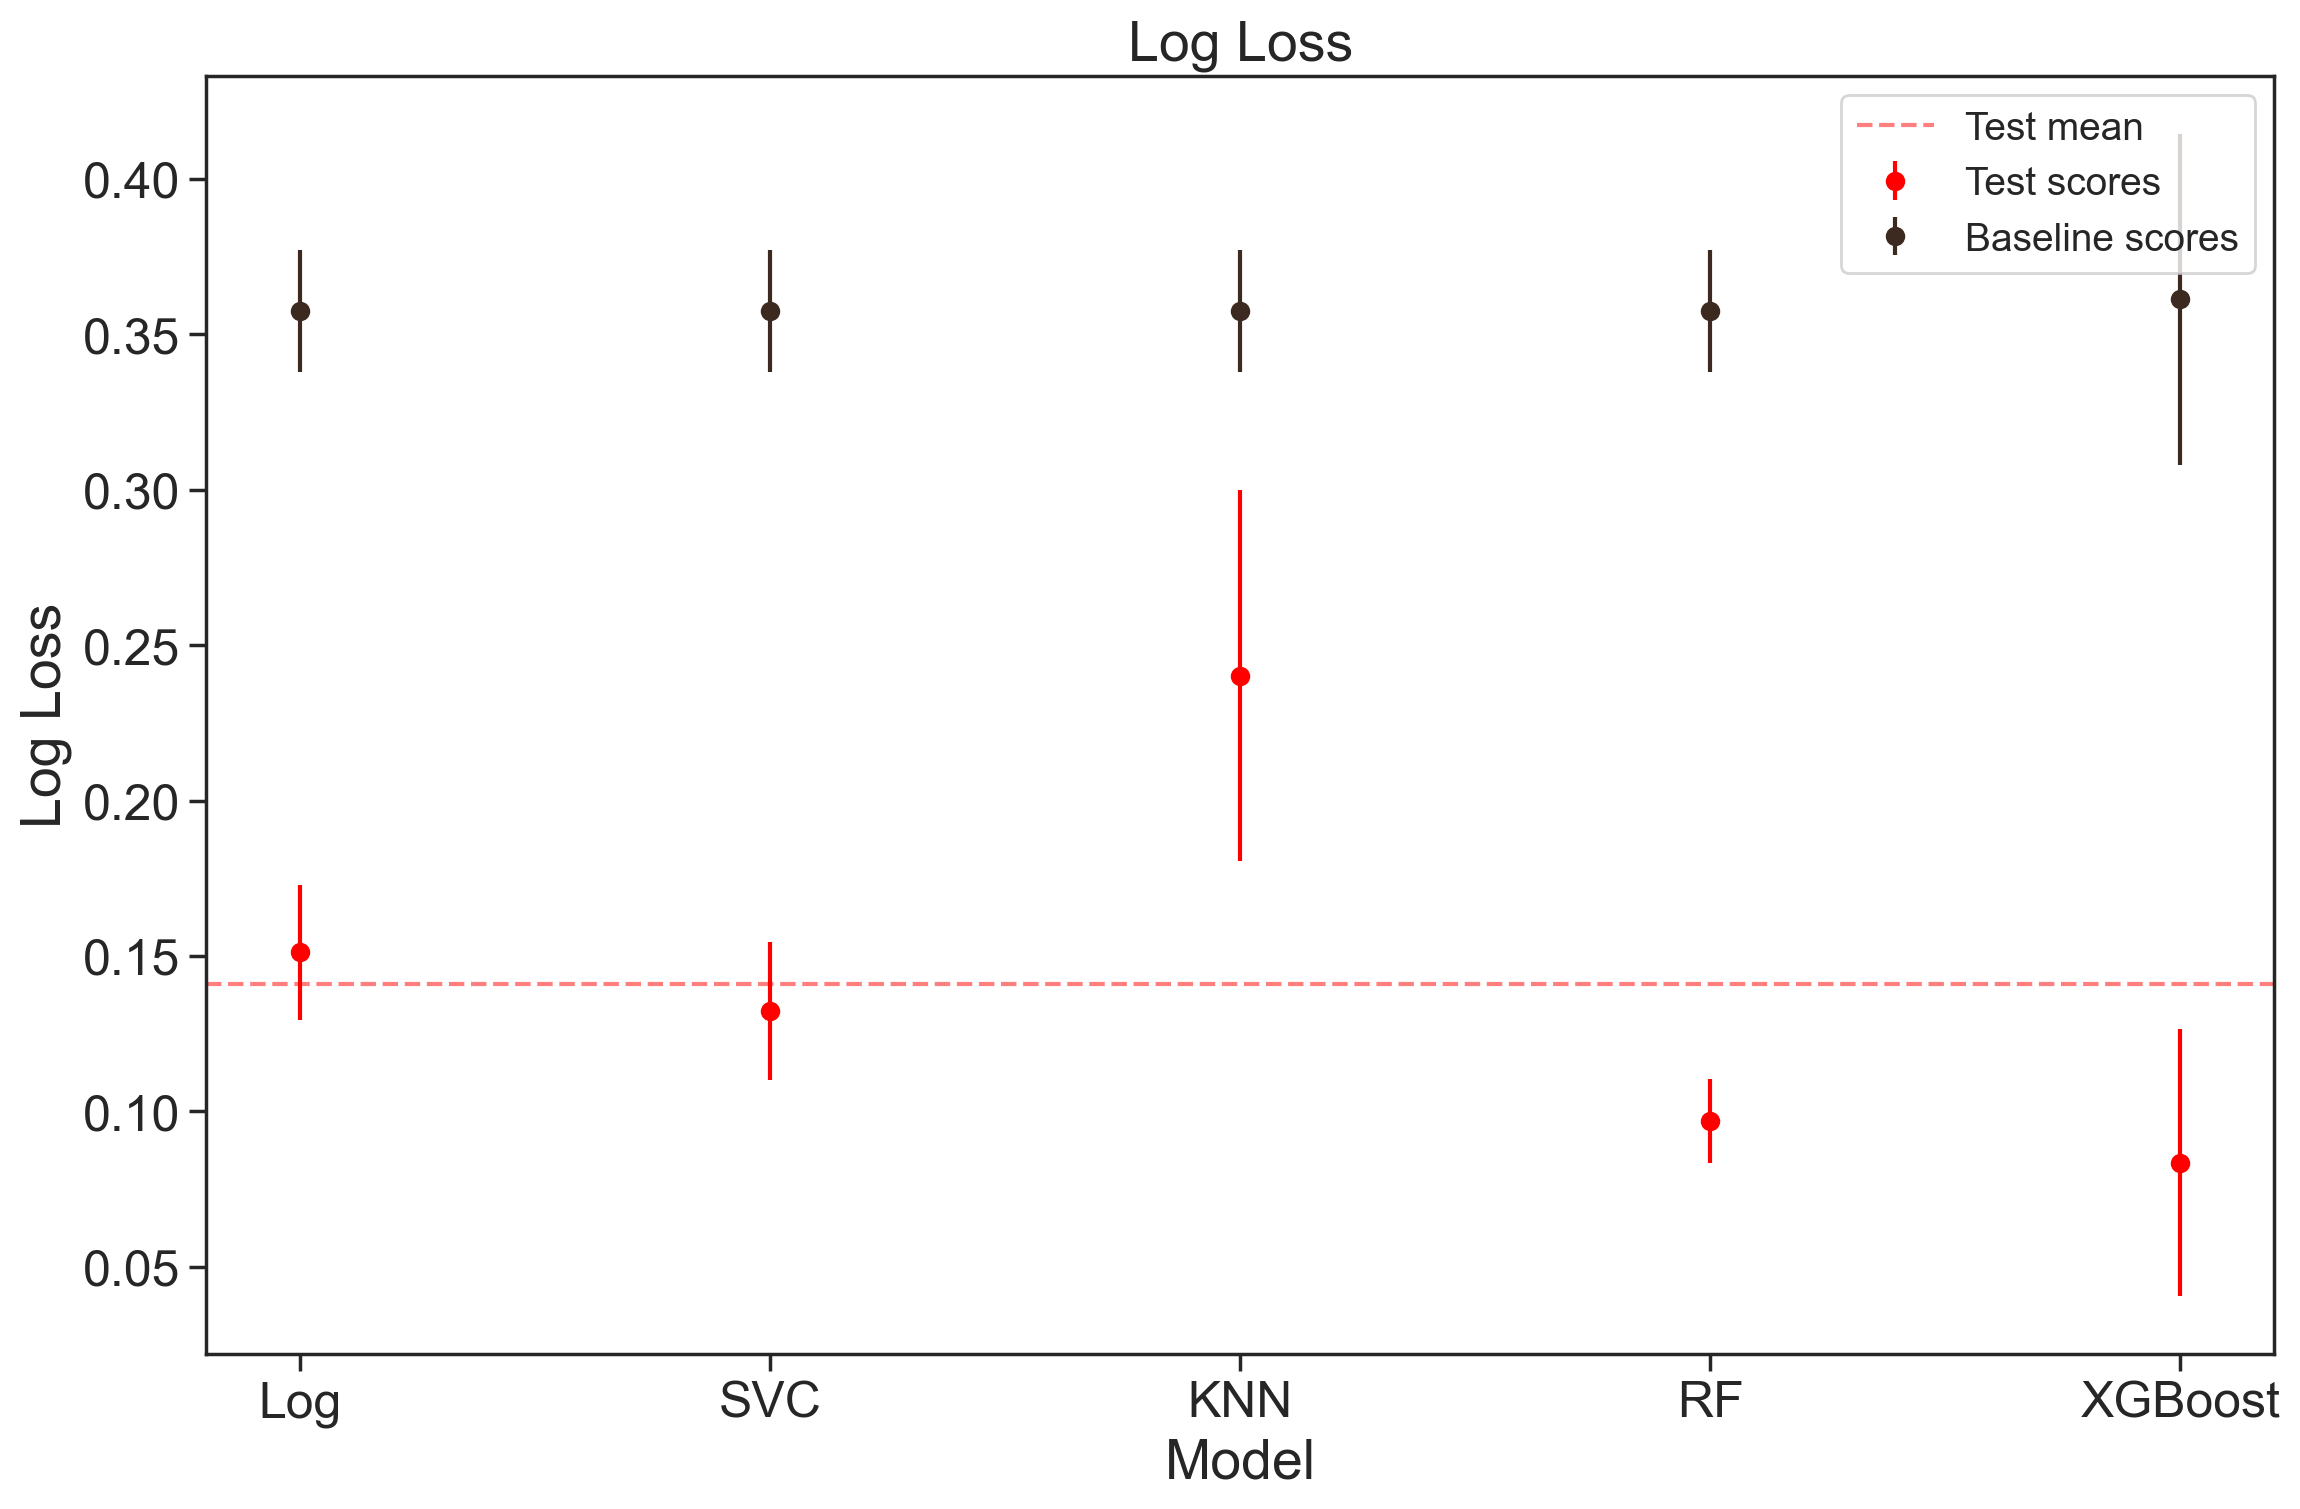

In [6]:
baseline_scores_df = pd.DataFrame(
    dict(zip(models, [_['baseline']['log_loss'] for _ in scores])))
test_scores_df = pd.DataFrame(
    dict(zip(models, [_['test']['log_loss'] for _ in scores])))
plt.errorbar(range(n_models),
             test_scores_df.mean(),
             yerr=test_scores_df.std(),
             fmt='o',
             label='Test scores',
             c=brown_colors[1])

plt.errorbar(range(n_models),
             baseline_scores_df.mean(),
             yerr=baseline_scores_df.std(),
             fmt='o',
             label='Baseline scores',
             c=brown_colors[0])
plt.axhline(test_scores_df.mean().mean(),
            color='r',
            linestyle='--',
            label='Test mean',
            c=brown_colors[1],
            alpha=0.5)
plt.xticks(range(n_models), test_scores_df.columns)
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.title('Log Loss')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/Results_LogLoss.png', dpi=400)
plt.savefig('../figures/Results_LogLoss.pdf', dpi=400)

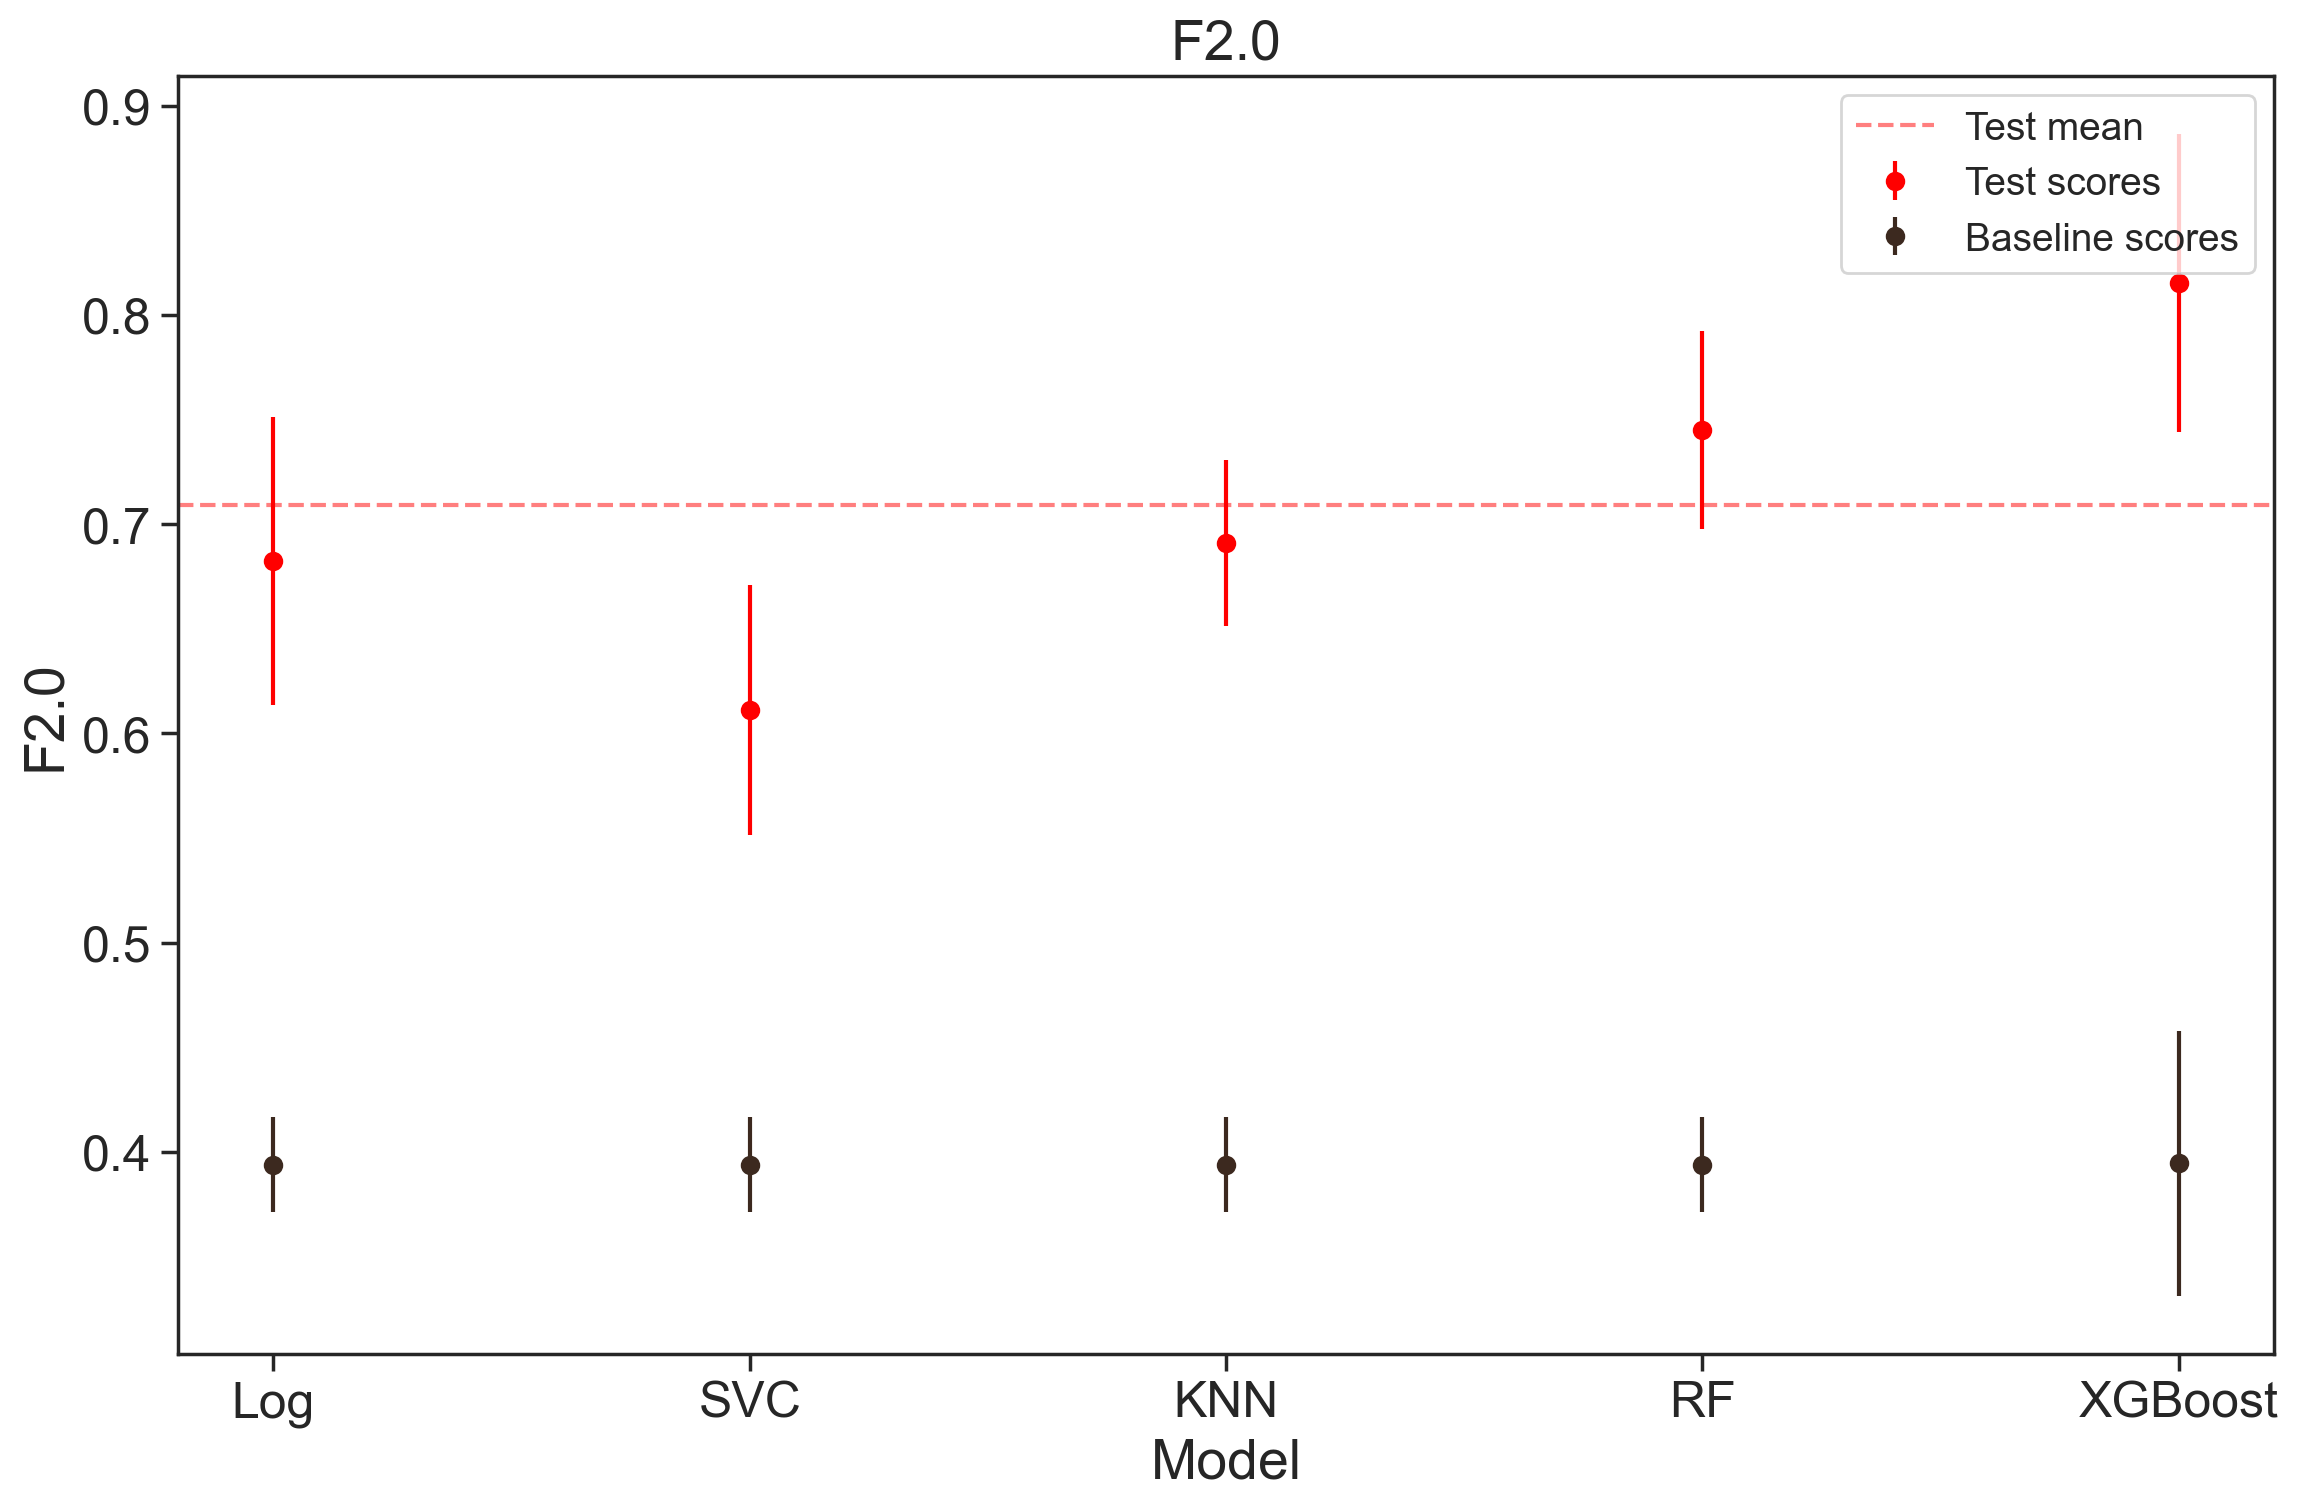

In [7]:
baseline_scores_df = pd.DataFrame(
    dict(zip(models, [_['baseline']['f2.0'] for _ in scores])))
test_scores_df = pd.DataFrame(
    dict(zip(models, [_['test']['f2.0'] for _ in scores])))
plt.errorbar(range(n_models),
             test_scores_df.mean(),
             yerr=test_scores_df.std(),
             fmt='o',
             label='Test scores',
             c=brown_colors[1])

plt.errorbar(range(n_models),
             baseline_scores_df.mean(),
             yerr=baseline_scores_df.std(),
             fmt='o',
             label='Baseline scores',
             c=brown_colors[0])
plt.axhline(test_scores_df.mean().mean(),
            color='r',
            linestyle='--',
            label='Test mean',
            c=brown_colors[1],
            alpha=0.5)
plt.xticks(range(n_models), test_scores_df.columns)
plt.xlabel('Model')
plt.ylabel('F2.0')
plt.title('F2.0')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/Results_F2.0.png', dpi=400)
plt.savefig('../figures/Results_F2.0.pdf', dpi=400)

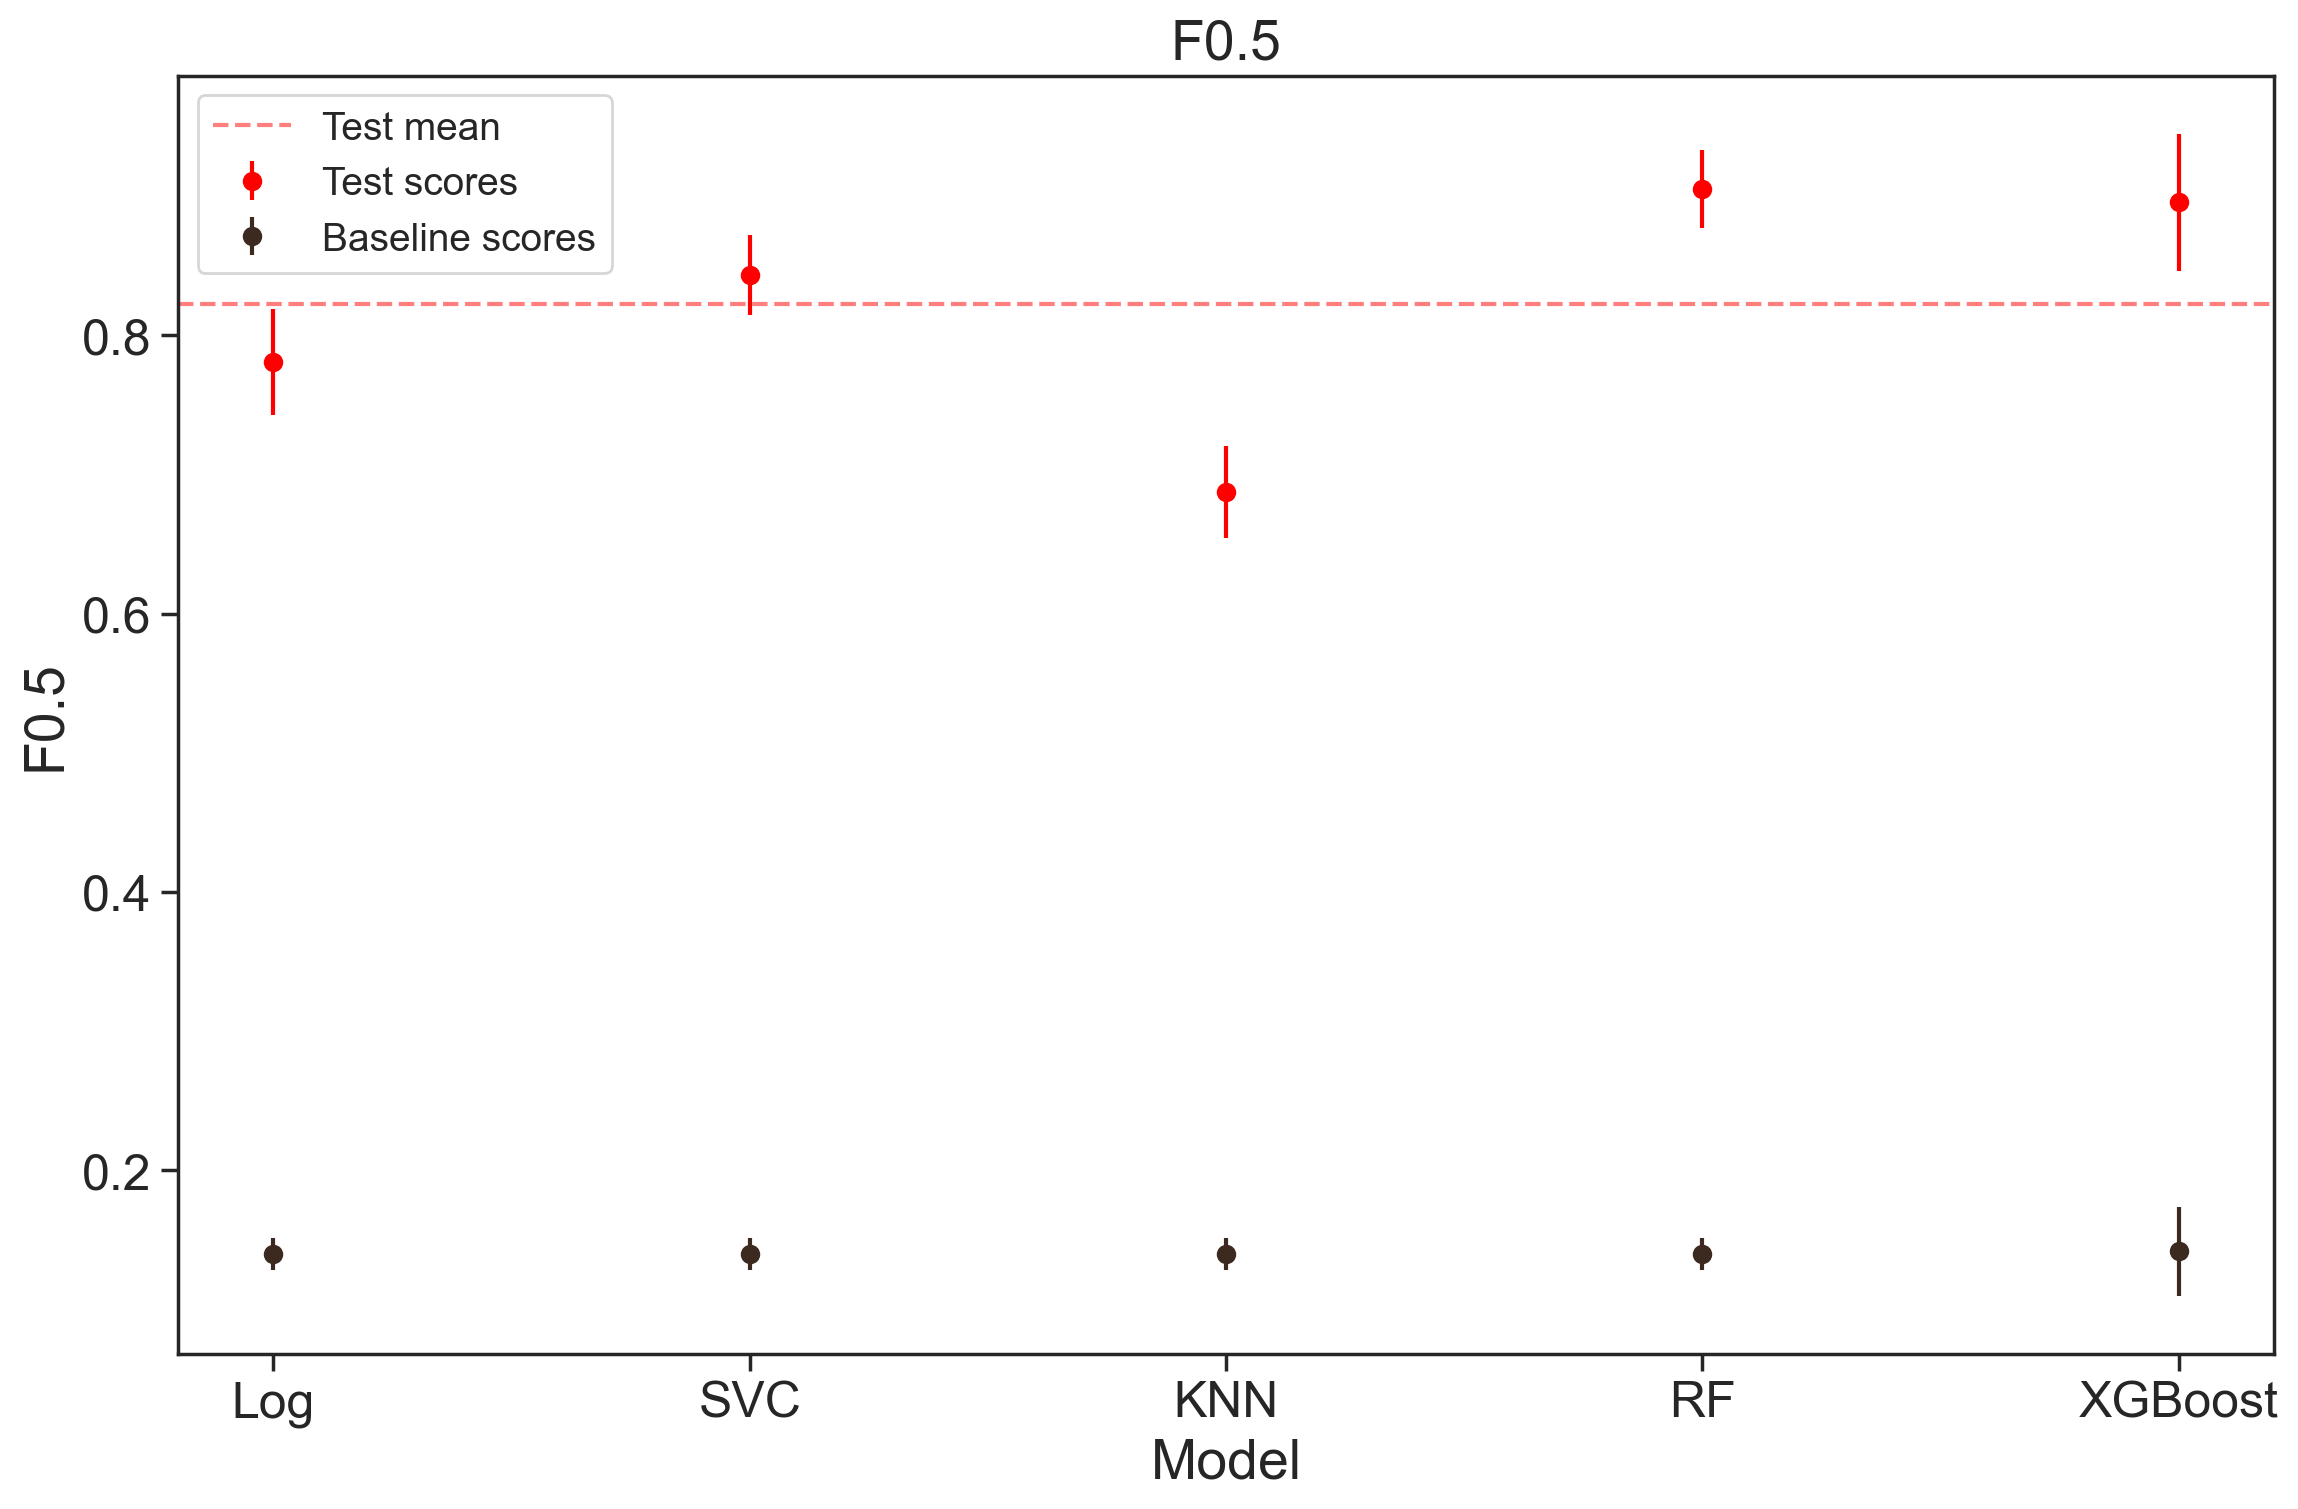

In [8]:
baseline_scores_df = pd.DataFrame(
    dict(zip(models, [_['baseline']['f0.5'] for _ in scores])))
test_scores_df = pd.DataFrame(
    dict(zip(models, [_['test']['f0.5'] for _ in scores])))
plt.errorbar(range(n_models),
             test_scores_df.mean(),
             yerr=test_scores_df.std(),
             fmt='o',
             label='Test scores',
             c=brown_colors[1])

plt.errorbar(range(n_models),
             baseline_scores_df.mean(),
             yerr=baseline_scores_df.std(),
             fmt='o',
             label='Baseline scores',
             c=brown_colors[0])
plt.axhline(test_scores_df.mean().mean(),
            color='r',
            linestyle='--',
            label='Test mean',
            c=brown_colors[1],
            alpha=0.5)
plt.xticks(range(n_models), test_scores_df.columns)
plt.xlabel('Model')
plt.ylabel('F0.5')
plt.title('F0.5')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/Results_F0.5.png', dpi=400)
plt.savefig('../figures/Results_F0.5.pdf', dpi=400)

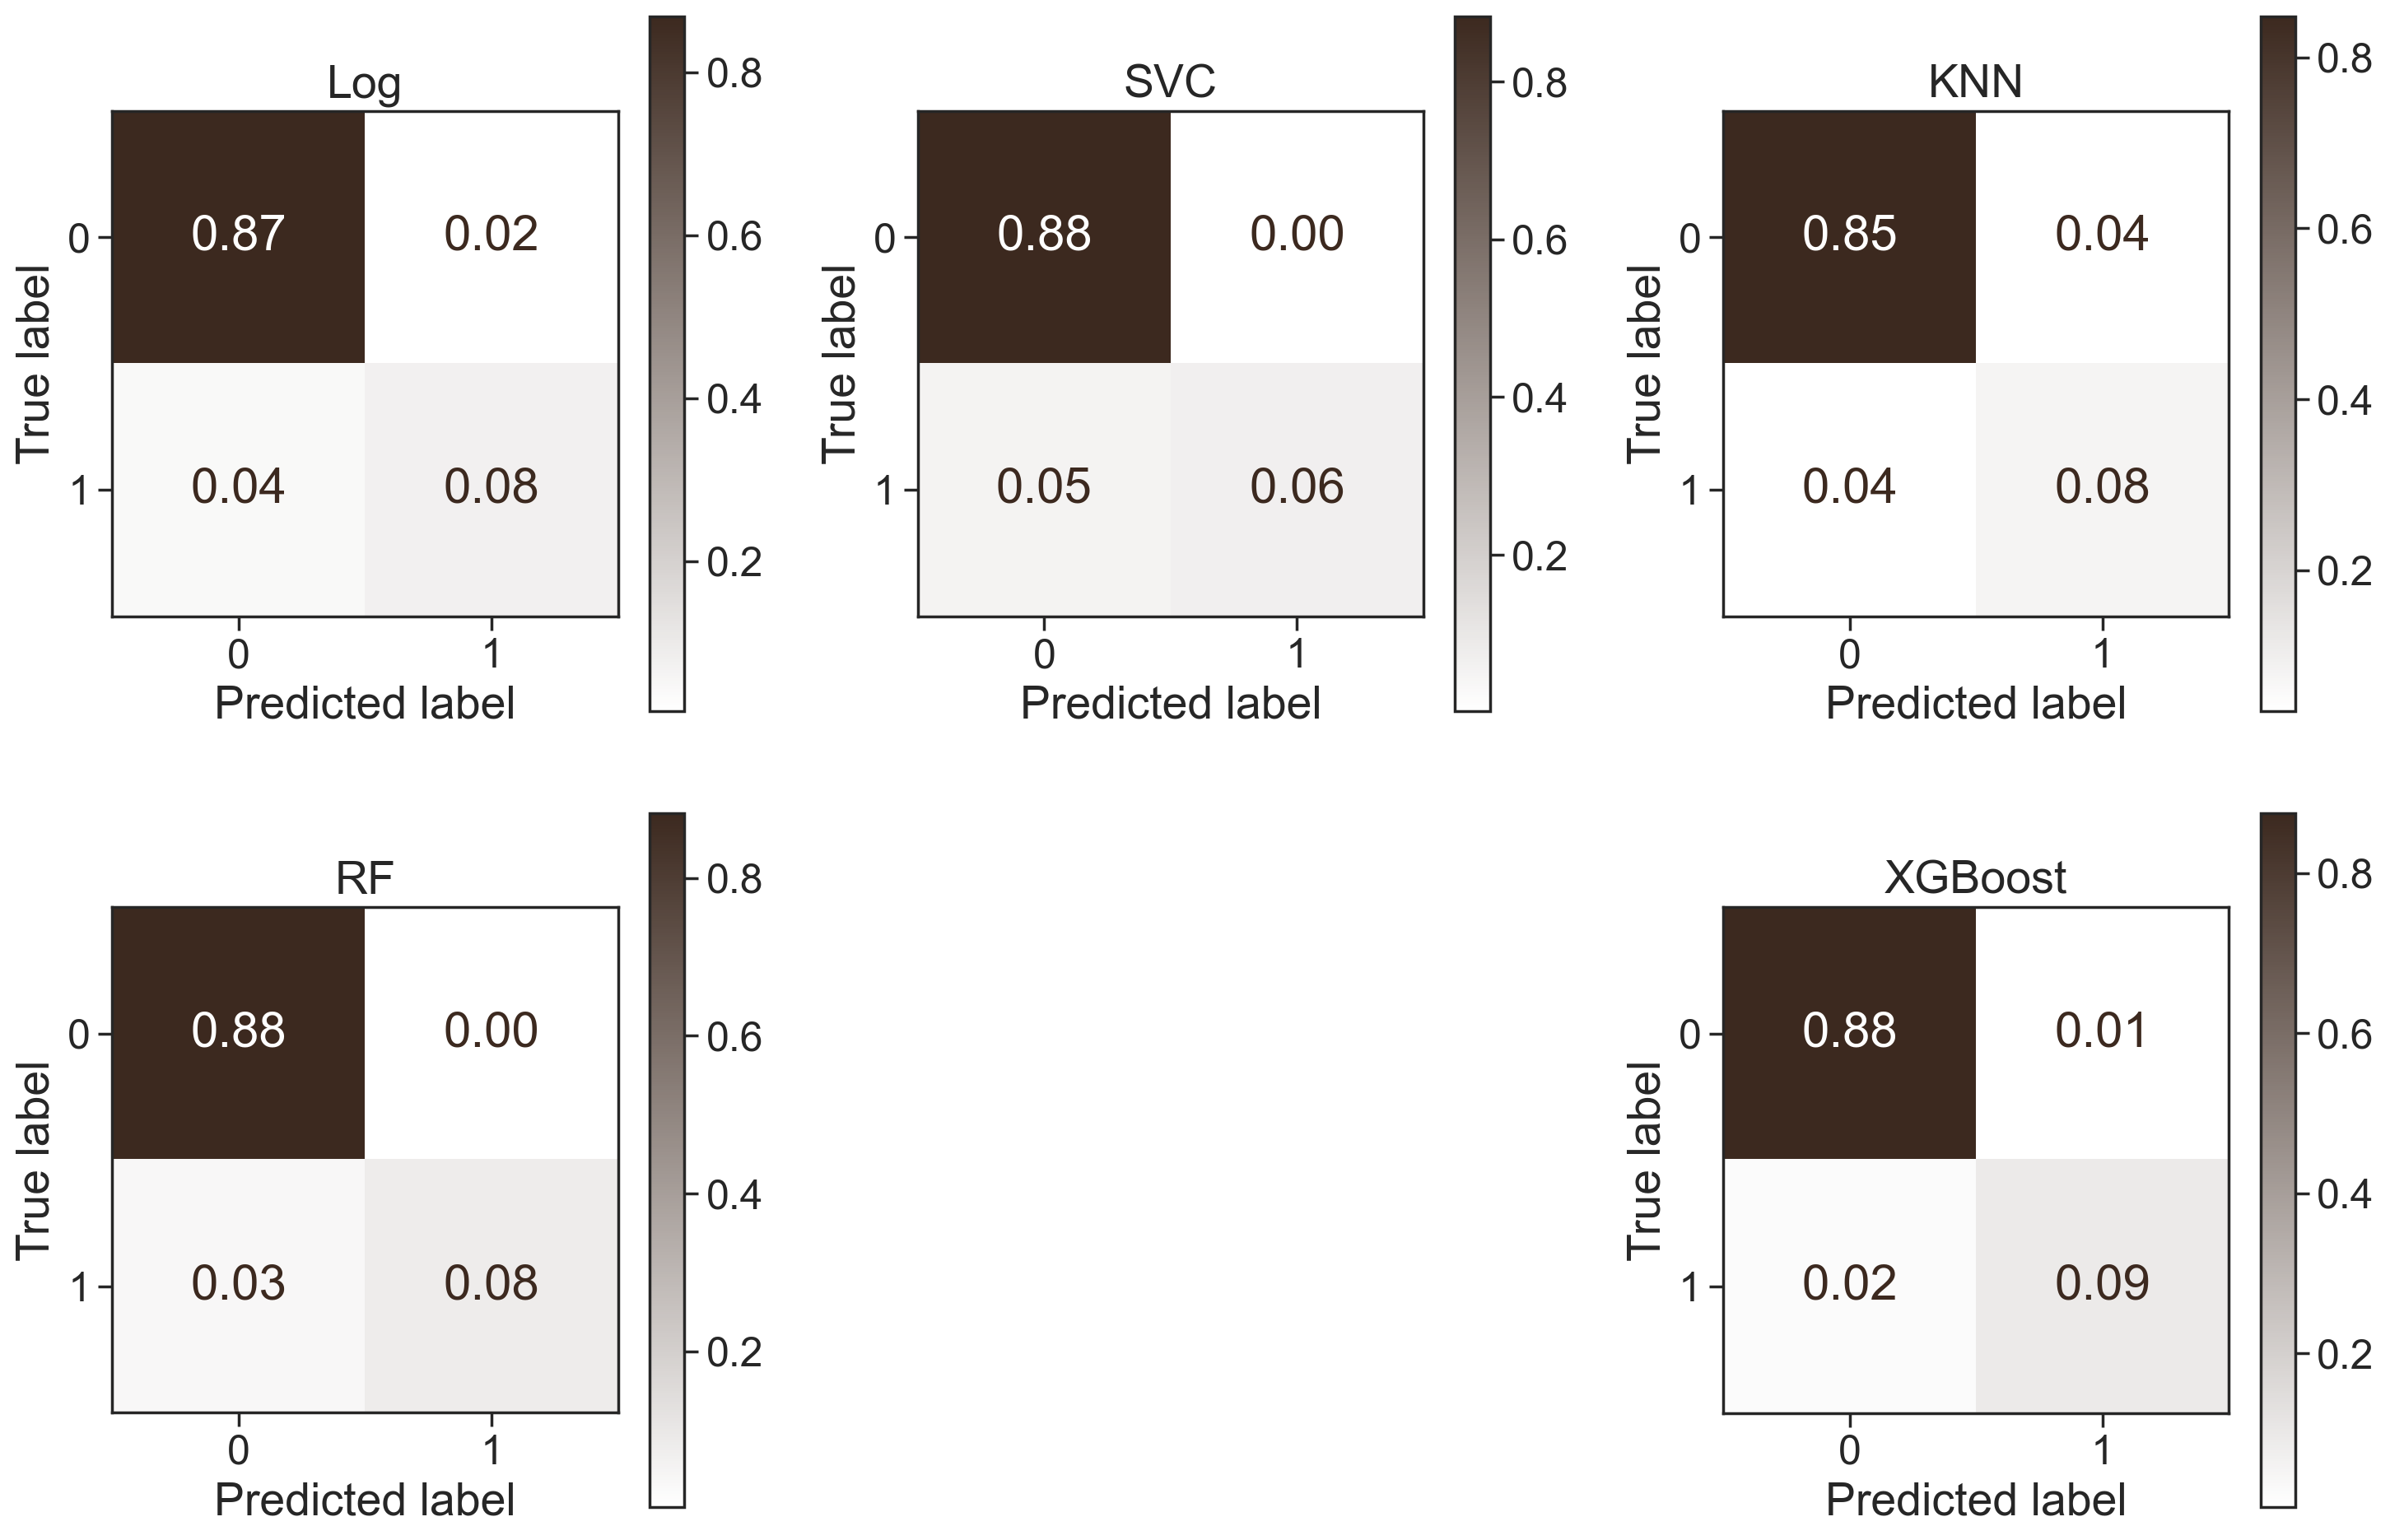

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
ax[-2], ax[-1] = ax[-1], ax[-2]
ax[-1].set_visible(False)
for i, cm in zip(range(n_models), (sum(_['test']['cm']) for _ in scores)):
    ConfusionMatrixDisplay(cm / cm.sum()).plot(ax=ax[i],
                                               cmap=Browns,
                                               values_format='.2f')
    ax[i].set(title=models[i],
              xlabel='Predicted label',
              ylabel='True label',
              xticks=[0, 1],
              yticks=[0, 1])

fig.tight_layout()
fig.savefig('../figures/ConfusionMatrix.png', dpi=400)
fig.savefig('../figures/ConfusionMatrix.pdf', dpi=400)

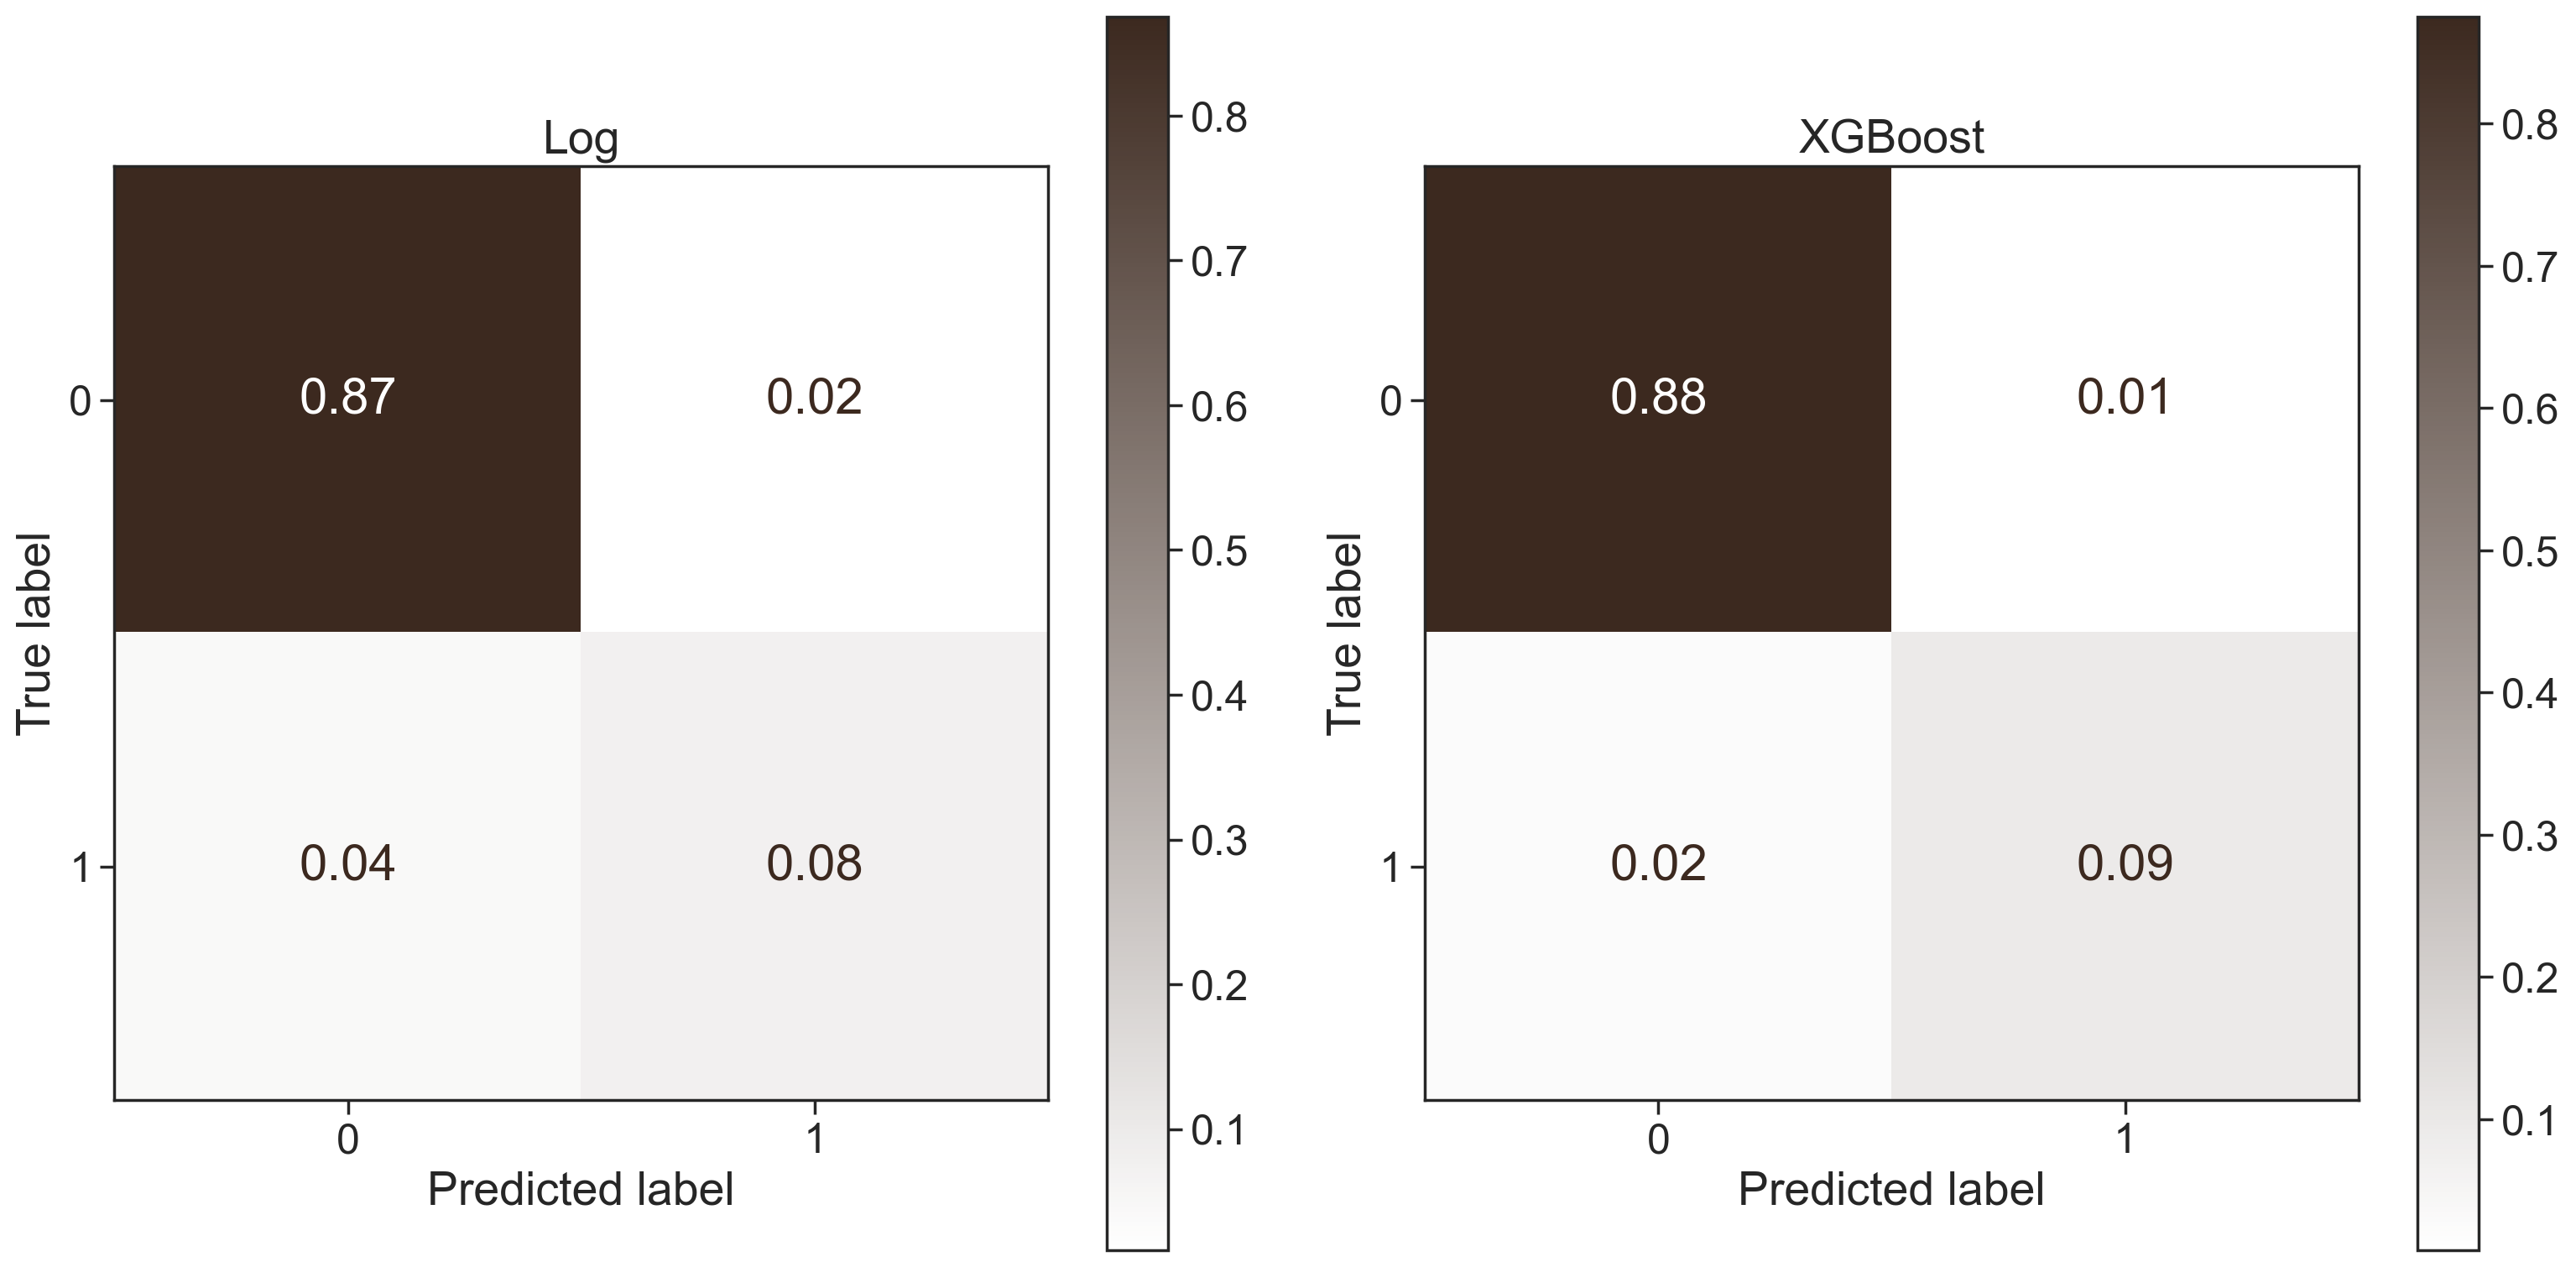

In [10]:
# Log vs XGBoost
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cm = sum(scores[0]['test']['cm'])
ConfusionMatrixDisplay(cm / cm.sum()).plot(ax=ax[0],
                                           cmap=Browns,
                                           values_format='.2f')
ax[0].set(title=models[0],
          xlabel='Predicted label',
          ylabel='True label',
          xticks=[0, 1],
          yticks=[0, 1])

cm = sum(scores[-1]['test']['cm'])
ConfusionMatrixDisplay(cm / cm.sum()).plot(ax=ax[1],
                                           cmap=Browns,
                                           values_format='.2f')
ax[1].set(title=models[-1],
          xlabel='Predicted label',
          ylabel='True label',
          xticks=[0, 1],
          yticks=[0, 1])

fig.tight_layout()
fig.savefig('../figures/ConfusionMatrix_Pair.png', dpi=400)
fig.savefig('../figures/ConfusionMatrix_Pair.pdf', dpi=400)

Loaded model ../results/results_XGBoost_0.pkl


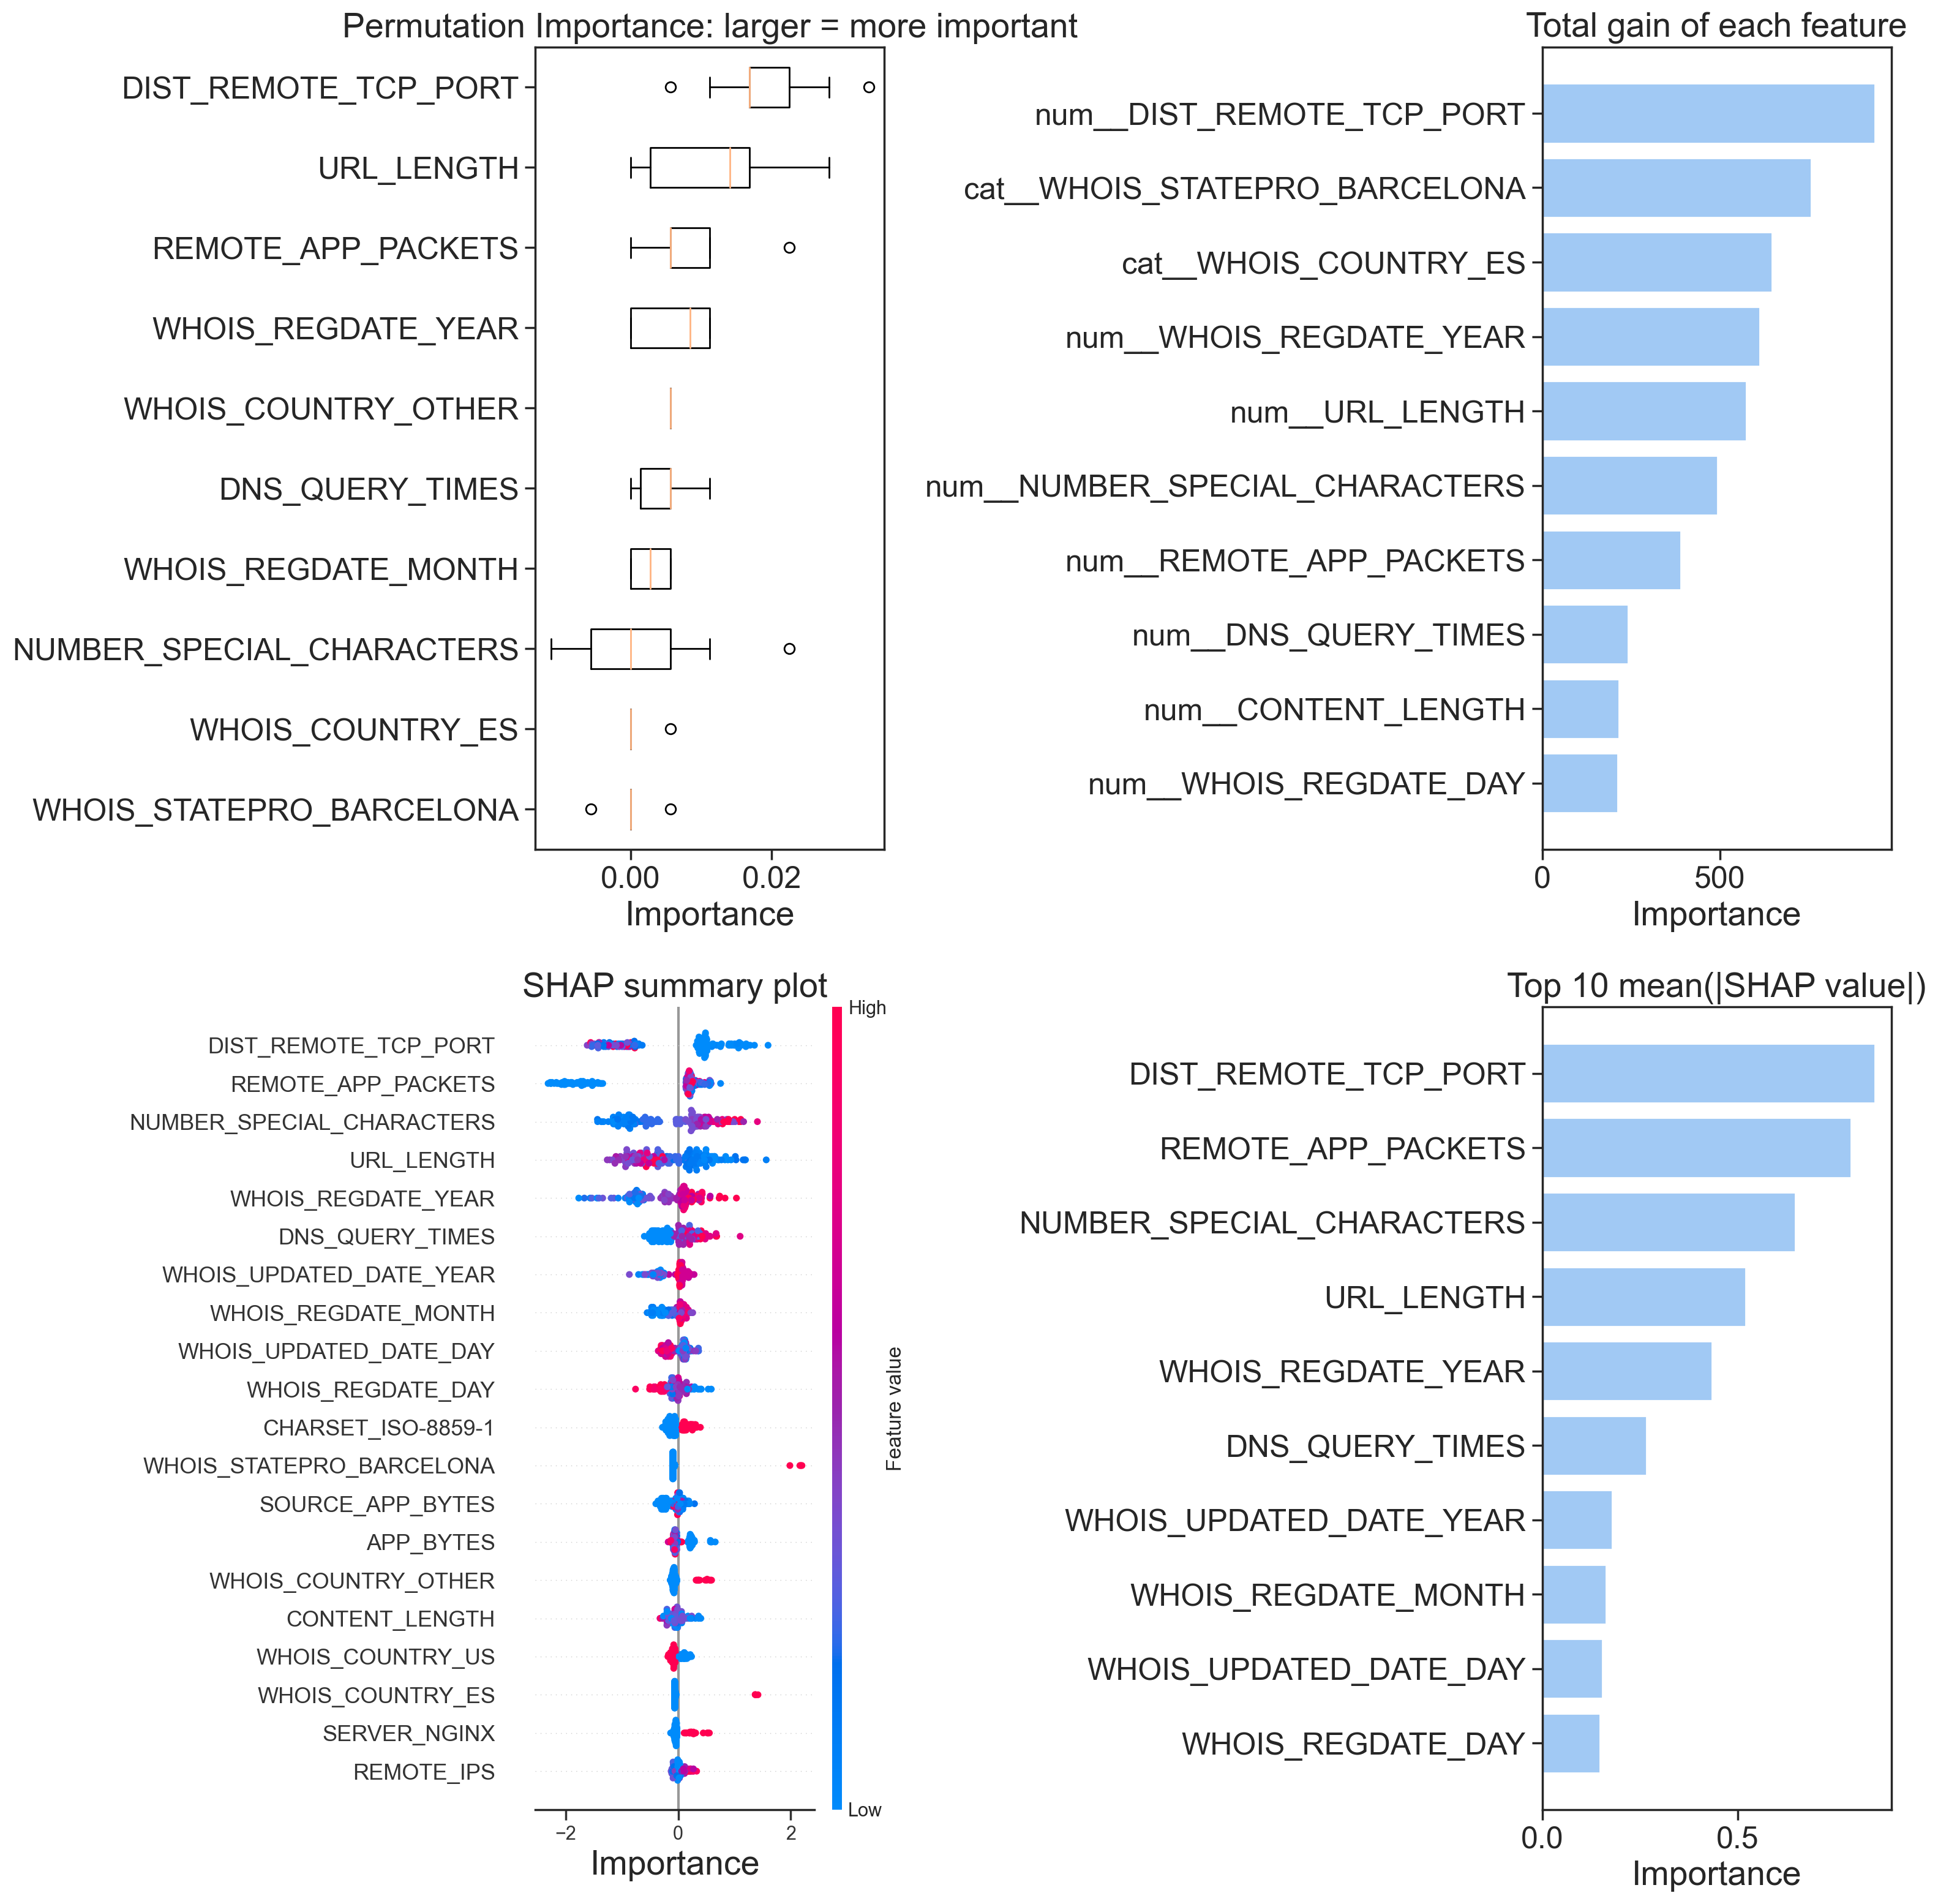

In [11]:
save_name = f'../results/results_XGBoost_0.pkl'
with open(save_name, 'rb') as f:
    explain_model, X_test, y_test = pickle.load(f)
    print('Loaded model', save_name)
feature_names = pd.Series([_[5:] for _ in X_test.columns])

plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
scores = permutation_importance(explain_model,
                                X_test,
                                y_test,
                                n_repeats=10,
                                random_state=SEED)

sorted_idx = scores.importances_mean.argsort()[~9:]
plt.boxplot(scores.importances[sorted_idx].T,
            labels=feature_names[sorted_idx],
            vert=False)
plt.title("Permutation Importance: larger = more important")
plt.xlabel('Importance')
plt.tight_layout()

plt.subplot(2, 2, 2)
top10 = lambda s: sorted(s.items(), key=lambda x: x[1], reverse=True)[:10]
importances = explain_model.get_booster().get_score(
    importance_type='total_gain')
plt.barh(*zip(*top10(importances)))
plt.title('Total gain of each feature')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
fig.tight_layout()

plt.subplot(2, 2, 3)
shap.initjs()
explainer = shap.Explainer(explain_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values,
                  X_test,
                  feature_names=feature_names,
                  plot_size=None,
                  show=False)
plt.title('SHAP summary plot')
plt.xlabel('Importance', fontsize=20)
plt.tight_layout()

plt.subplot(2, 2, 4)
feature_shap_means = np.abs(shap_values.values).mean(axis=0)
idxs = feature_shap_means.argsort()[-10:]
plt.title('Top 10 mean(|SHAP value|)')
plt.barh(feature_names[idxs], feature_shap_means[idxs])
plt.xlabel('Importance')
plt.tight_layout()

plt.savefig('../figures/FeatureImportance.png', dpi=400)
plt.savefig('../figures/FeatureImportance.pdf', dpi=400)

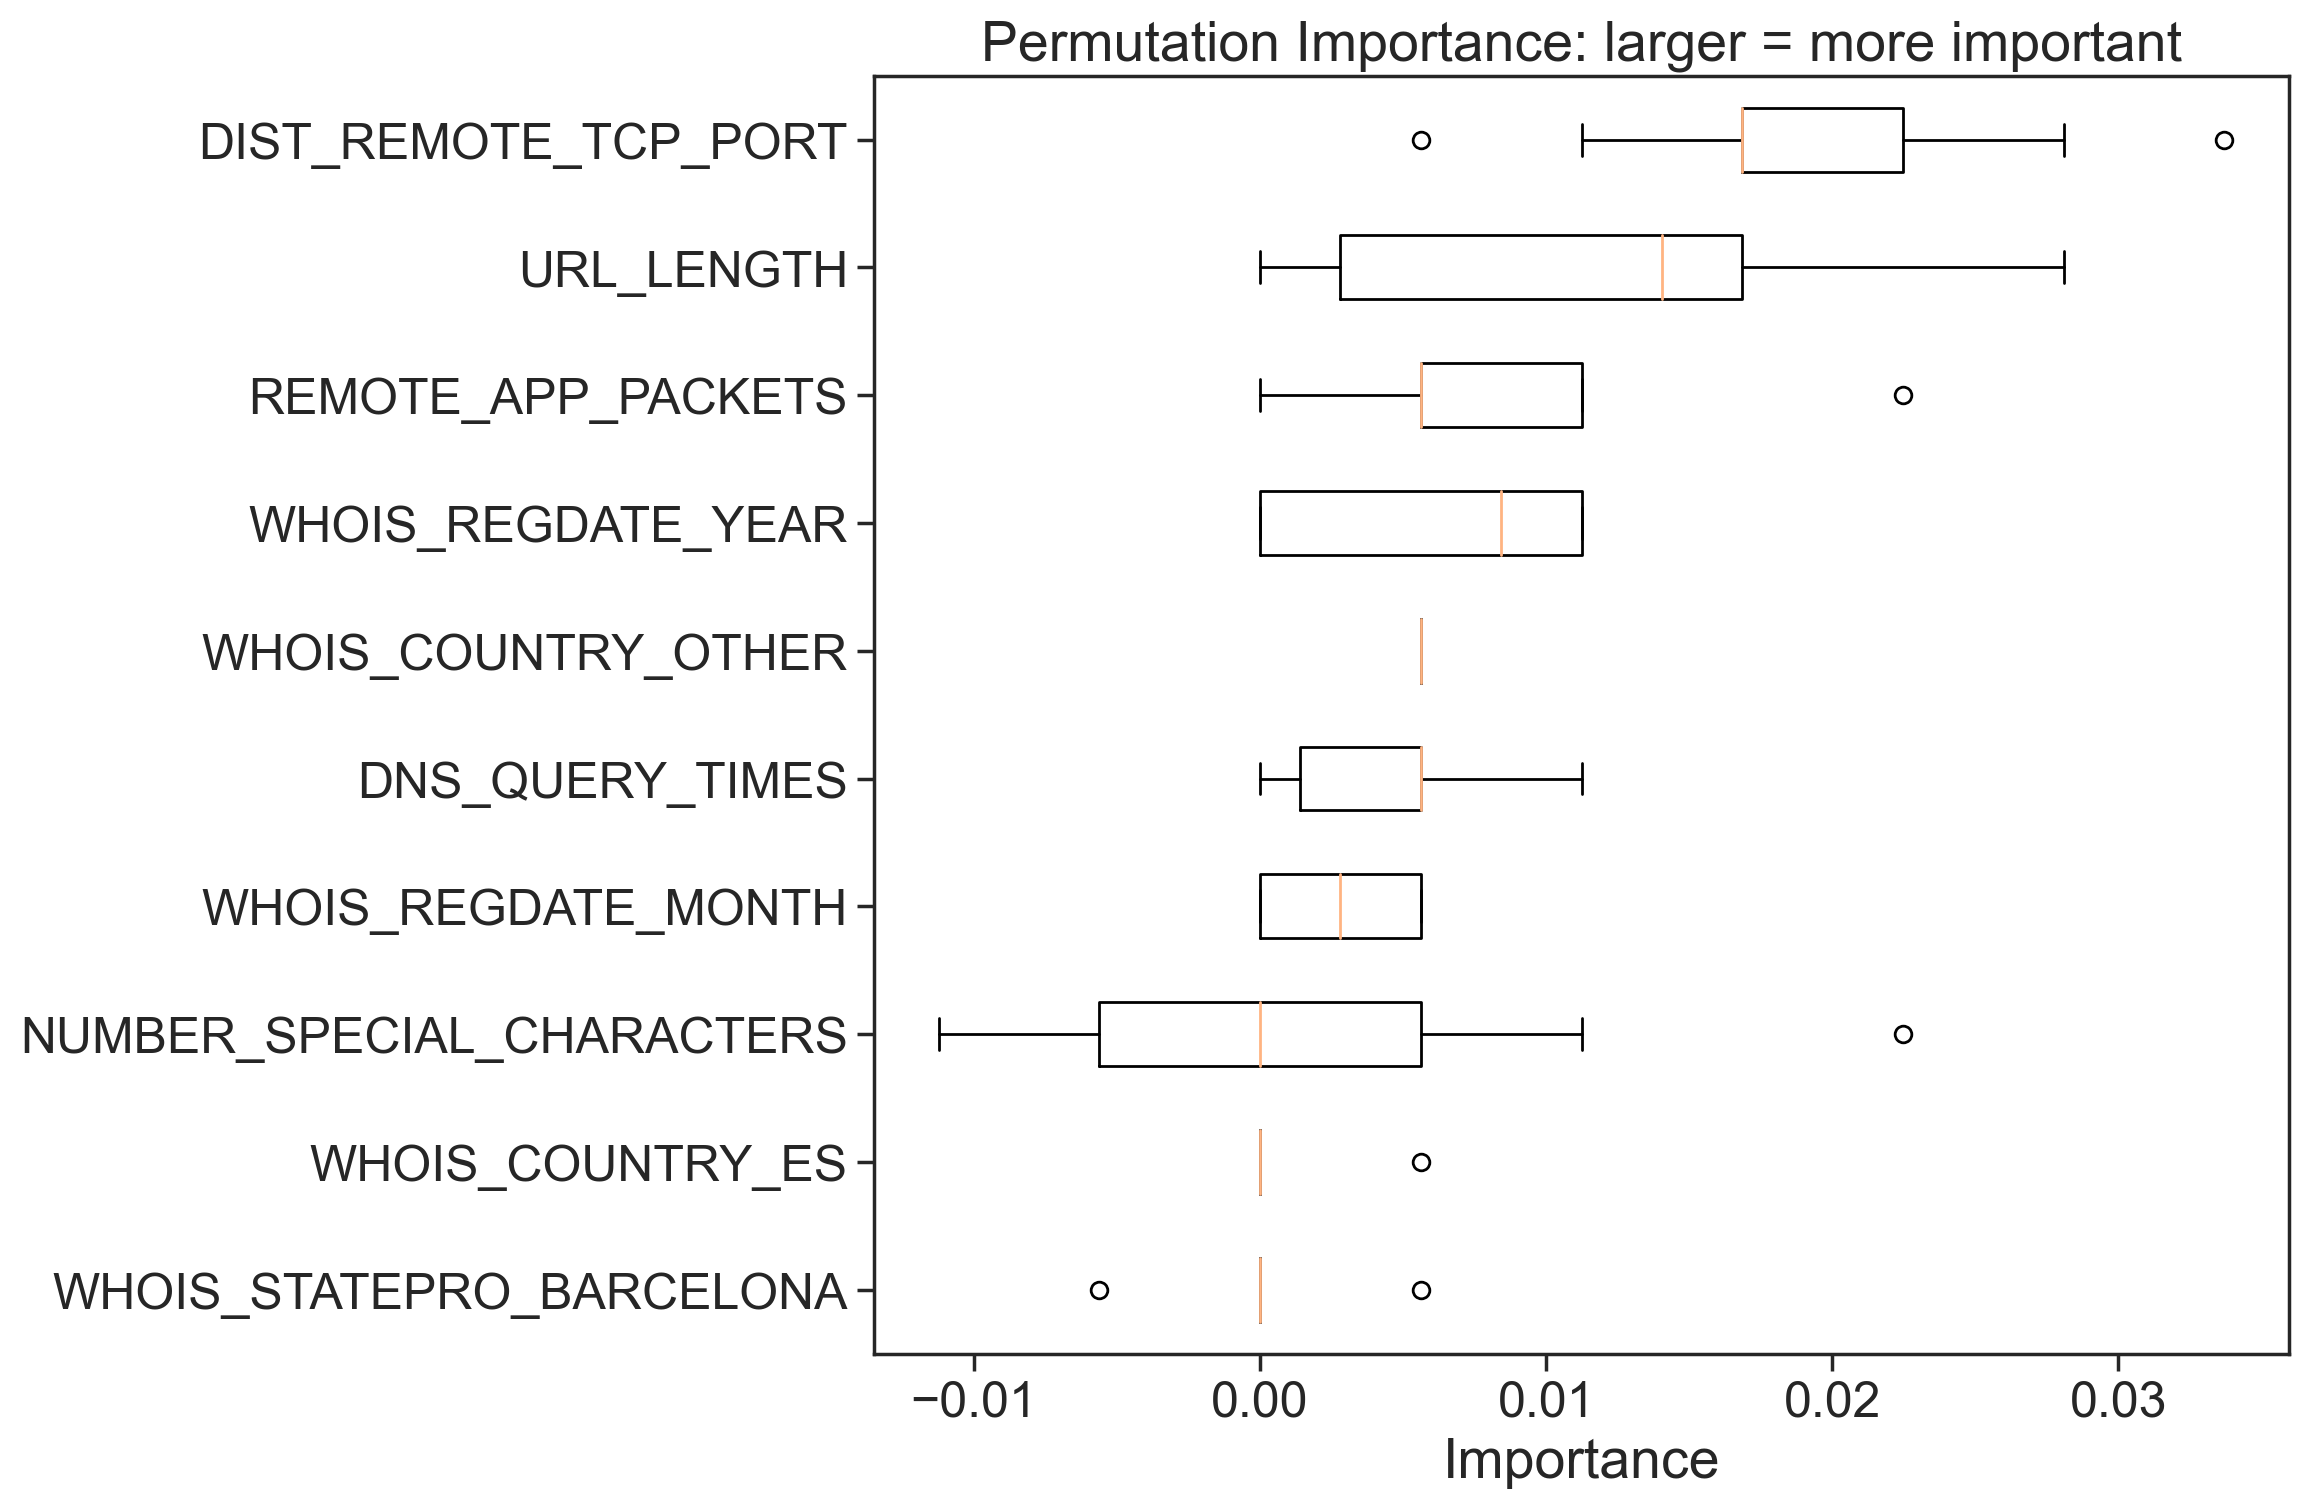

In [12]:
scores = permutation_importance(explain_model,
                                X_test,
                                y_test,
                                n_repeats=10,
                                random_state=SEED)

sorted_idx = scores.importances_mean.argsort()[~9:]
plt.boxplot(scores.importances[sorted_idx].T,
            labels=feature_names[sorted_idx],
            vert=False)
plt.title("Permutation Importance: larger = more important")
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../figures/FeatureImportance_Perm.png', dpi=400)
plt.savefig('../figures/FeatureImportance_Perm.pdf', dpi=400)

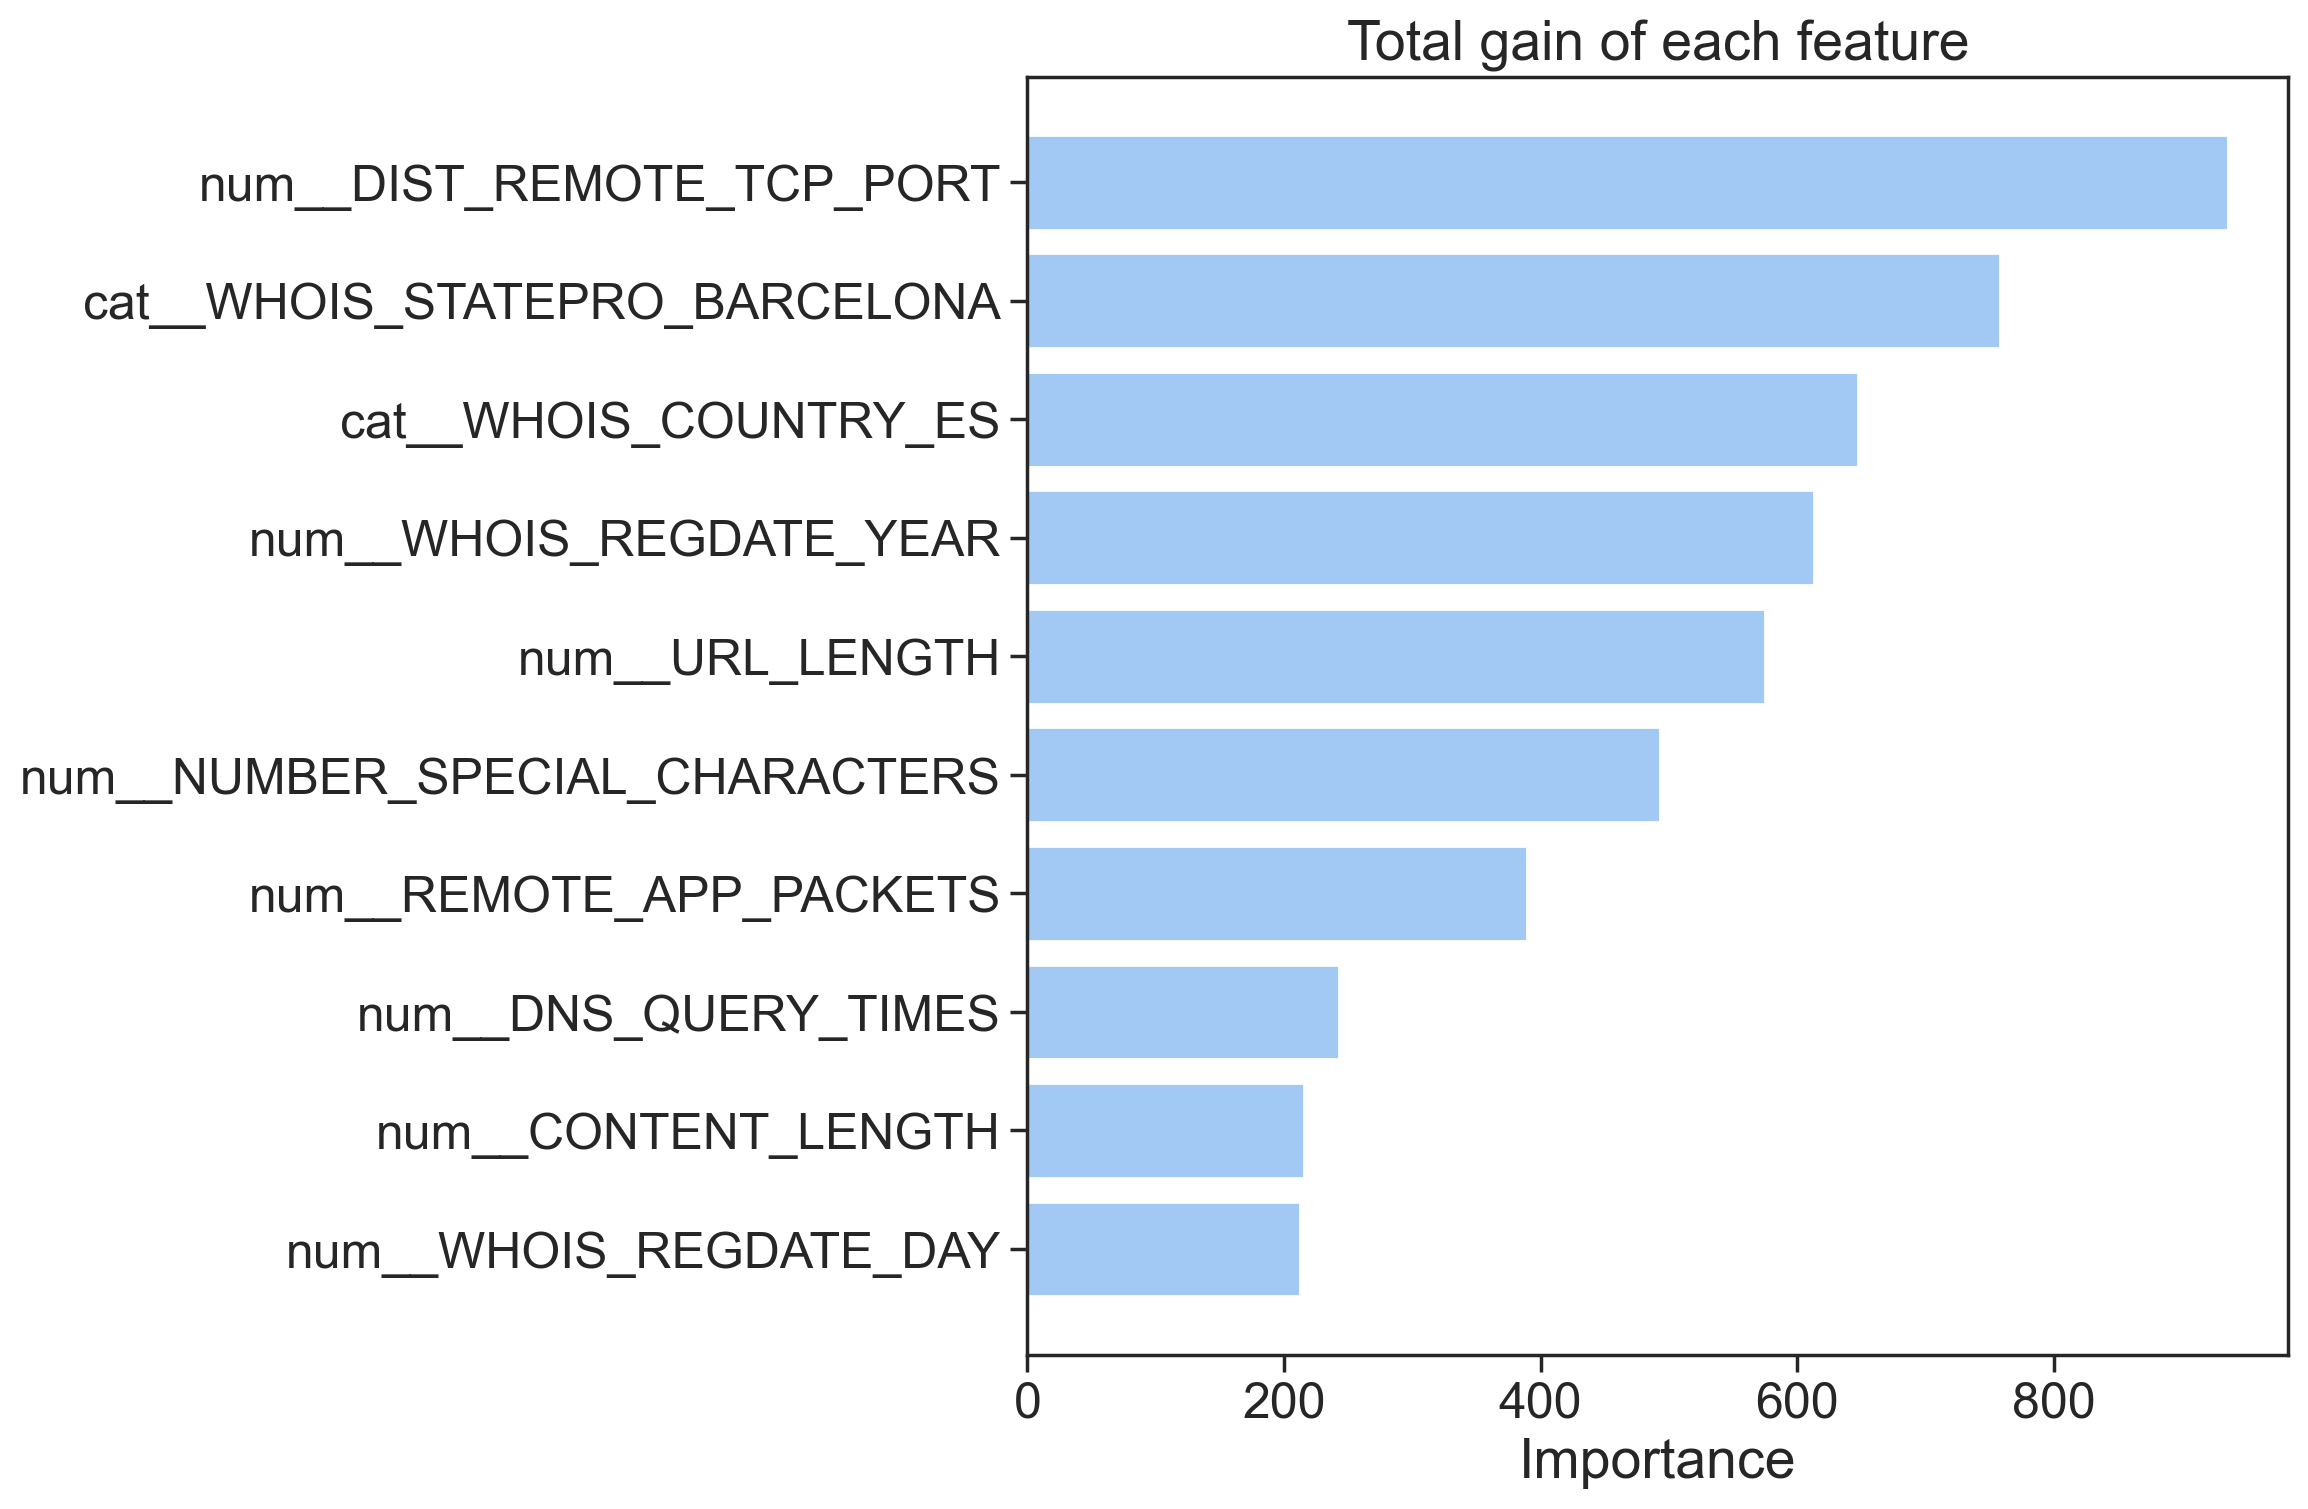

In [13]:
top10 = lambda s: sorted(s.items(), key=lambda x: x[1], reverse=True)[:10]
importances = explain_model.get_booster().get_score(
    importance_type='total_gain')
plt.barh(*zip(*top10(importances)))
plt.title('Total gain of each feature')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('../figures/FeatureImportance_Gain.png', dpi=400)
plt.savefig('../figures/FeatureImportance_Gain.pdf', dpi=400)

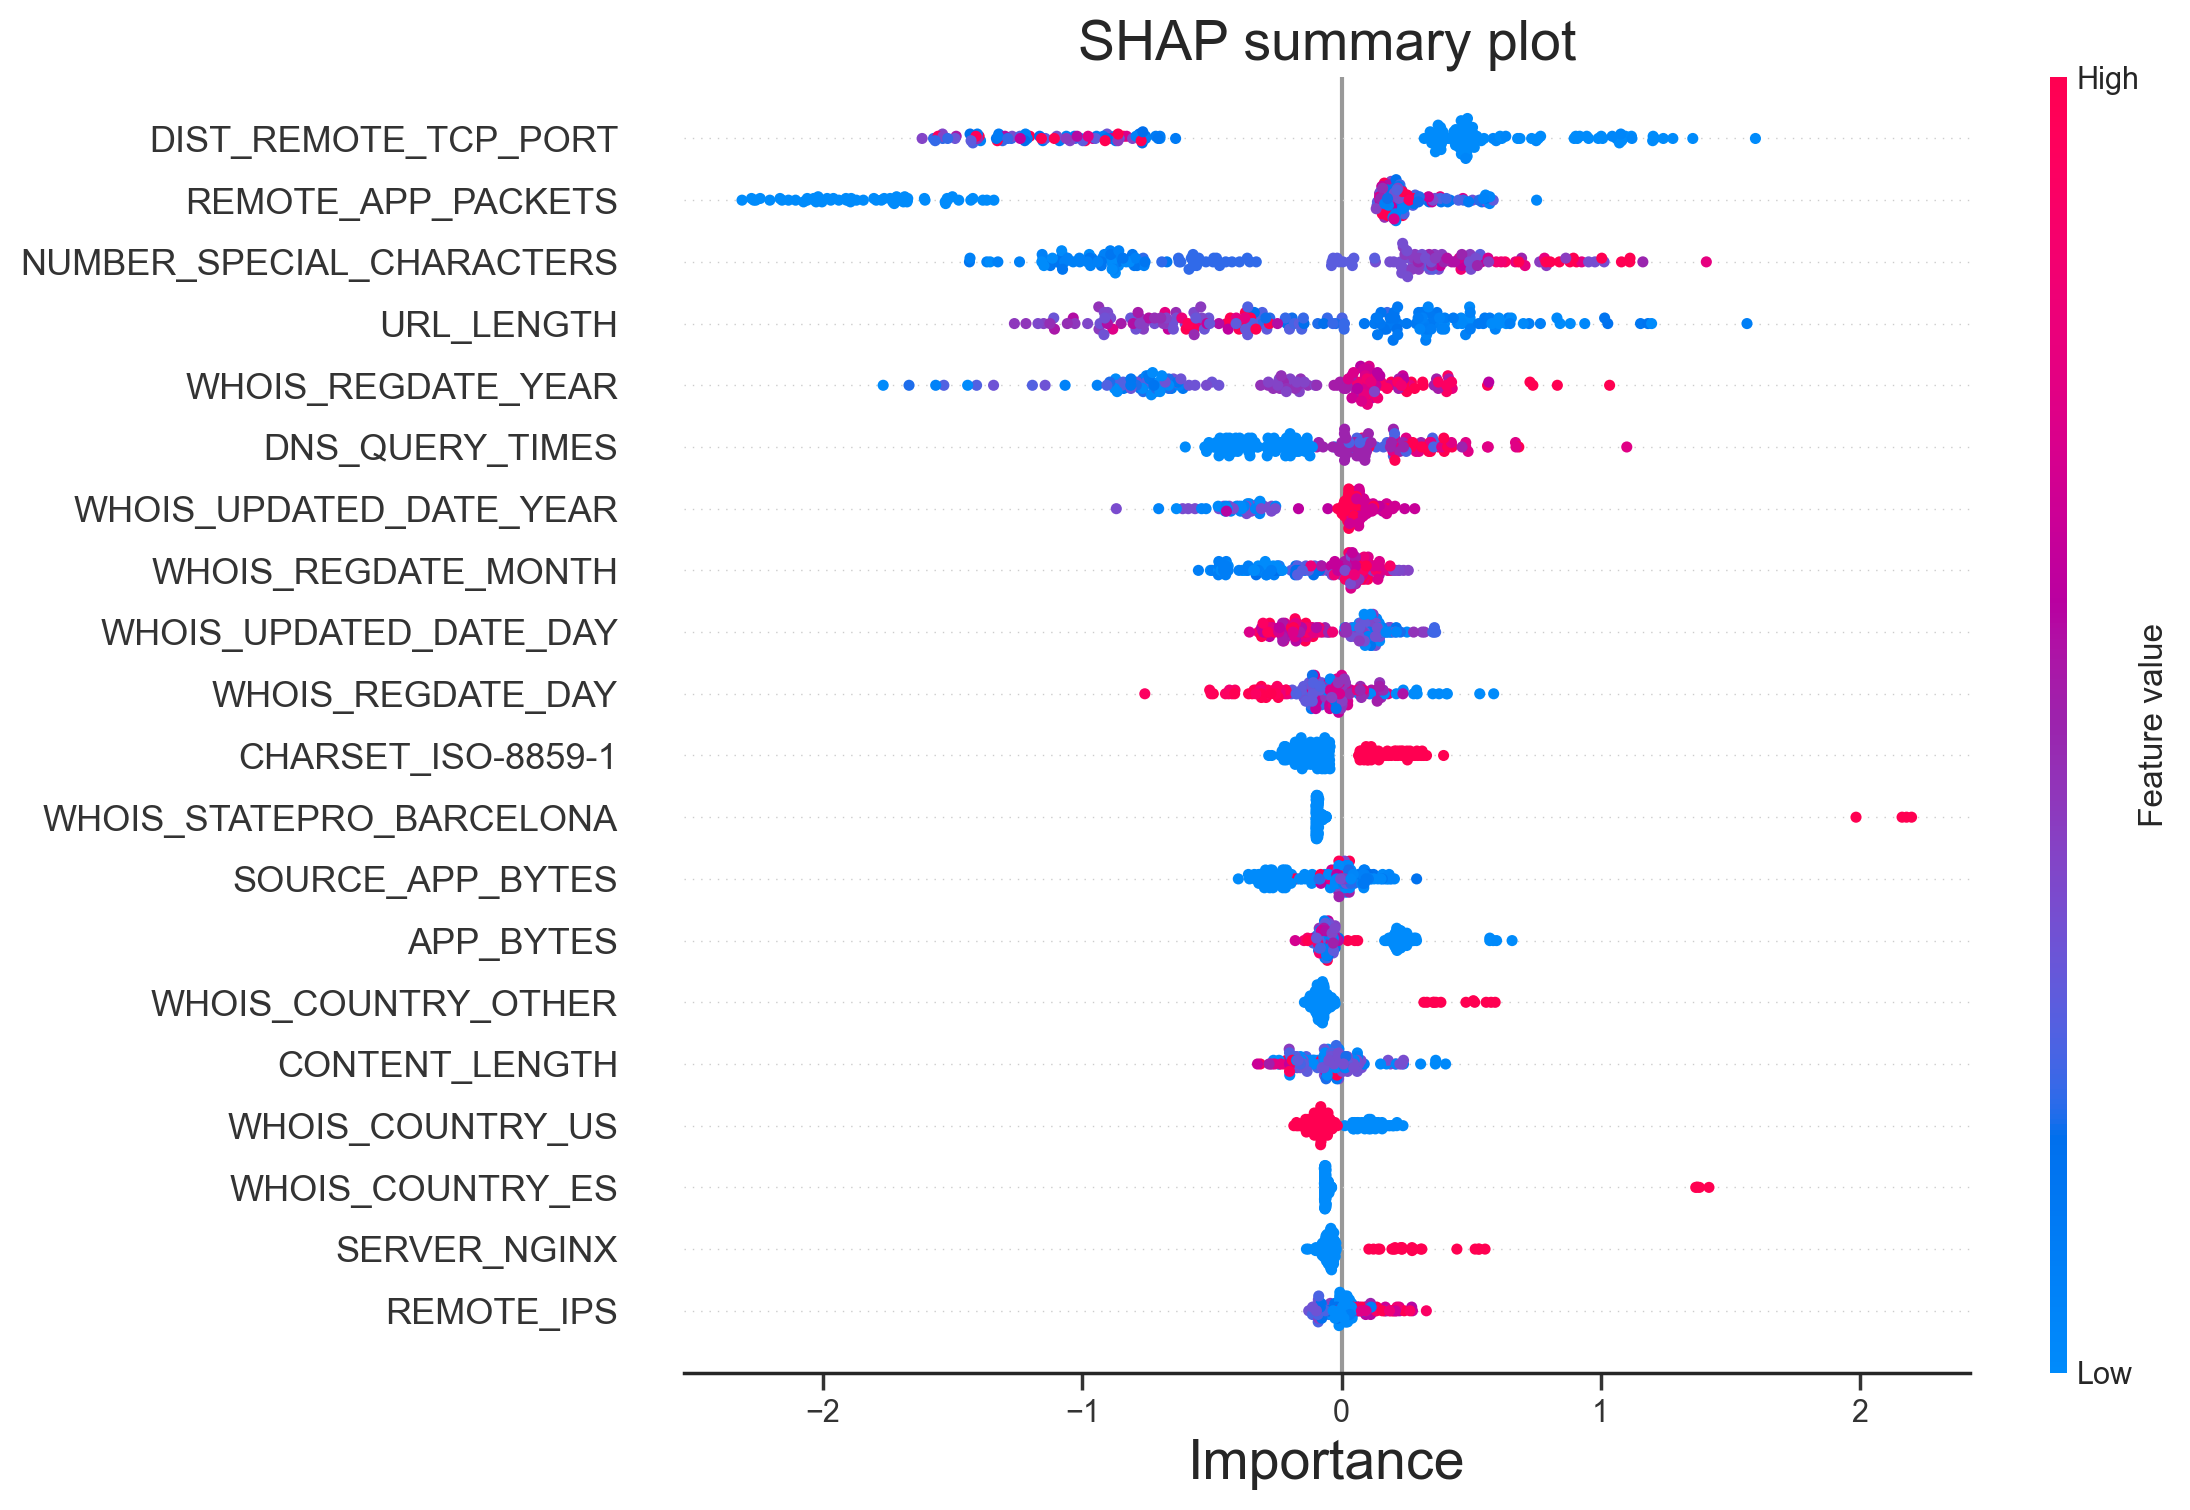

In [14]:
shap.summary_plot(shap_values,
                  X_test,
                  feature_names=feature_names,
                  plot_size=None,
                  show=False)
plt.title('SHAP summary plot')
plt.xlabel('Importance', fontsize=20)
plt.tight_layout()

plt.savefig('../figures/FeatureImportance_SHAP.png', dpi=400)
plt.savefig('../figures/FeatureImportance_SHAP.pdf', dpi=400)

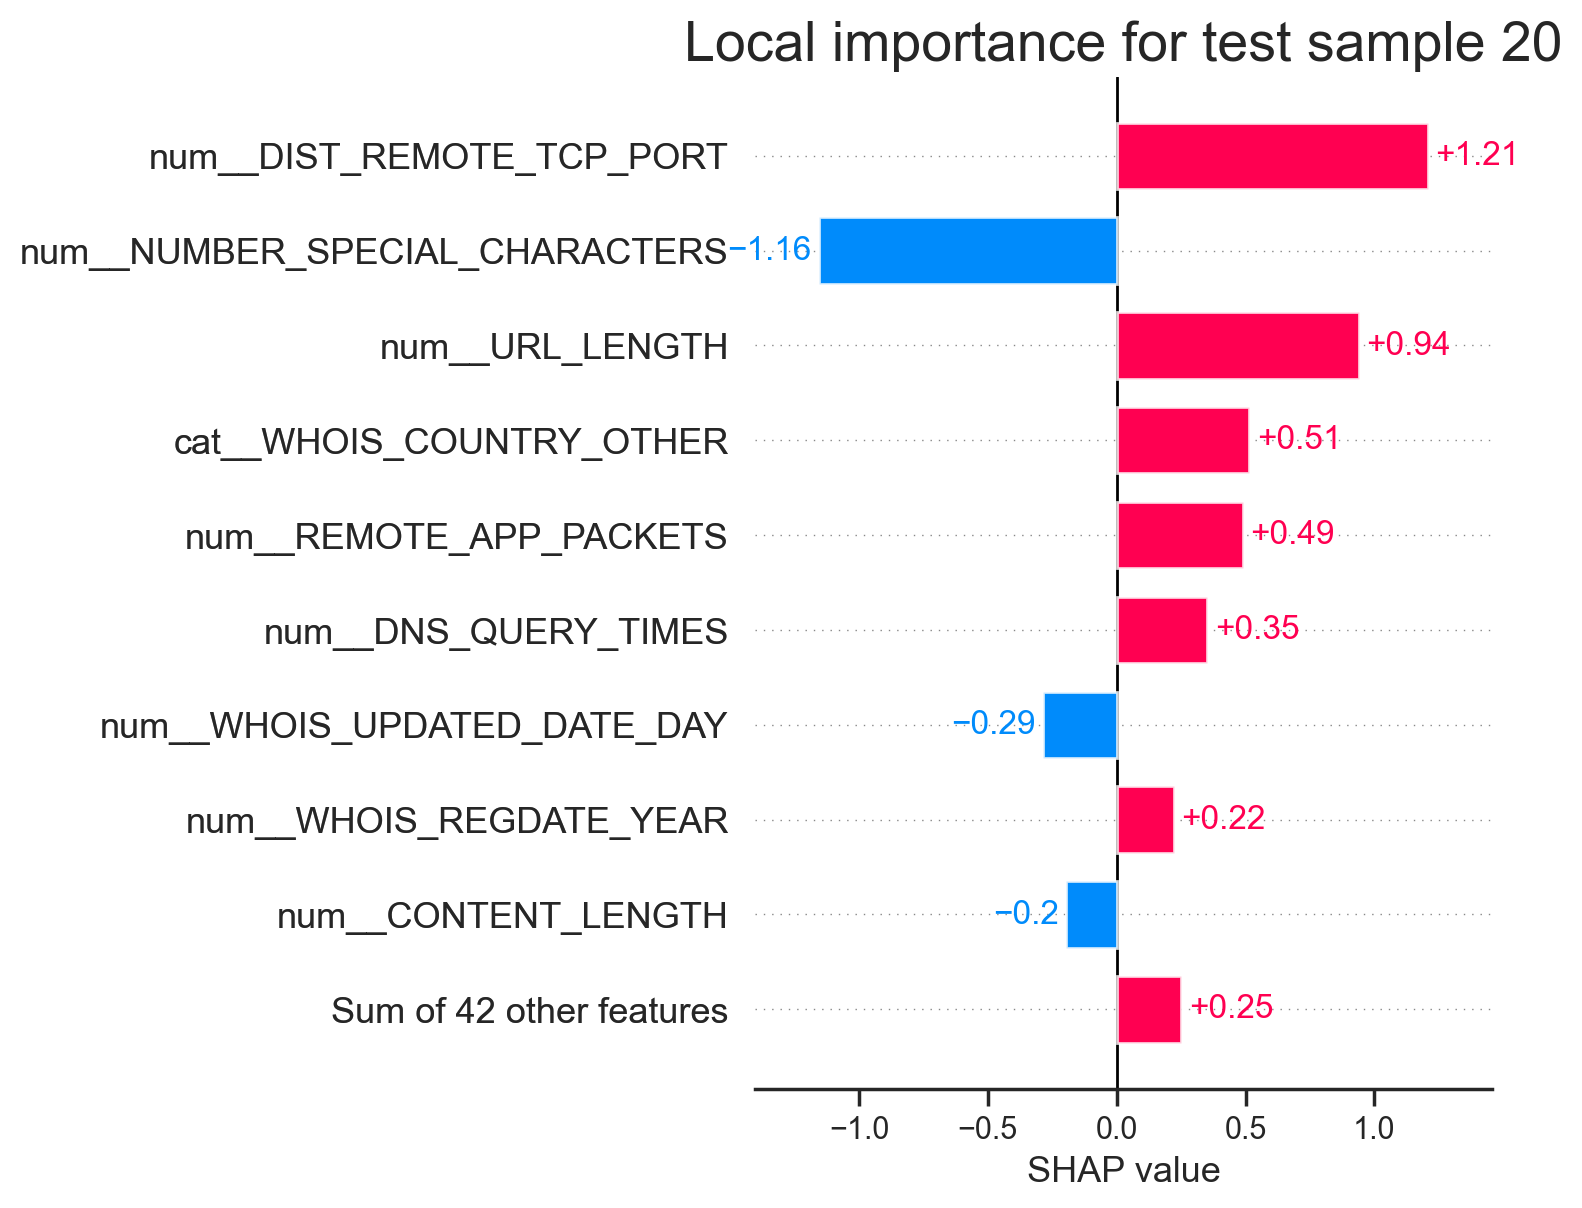

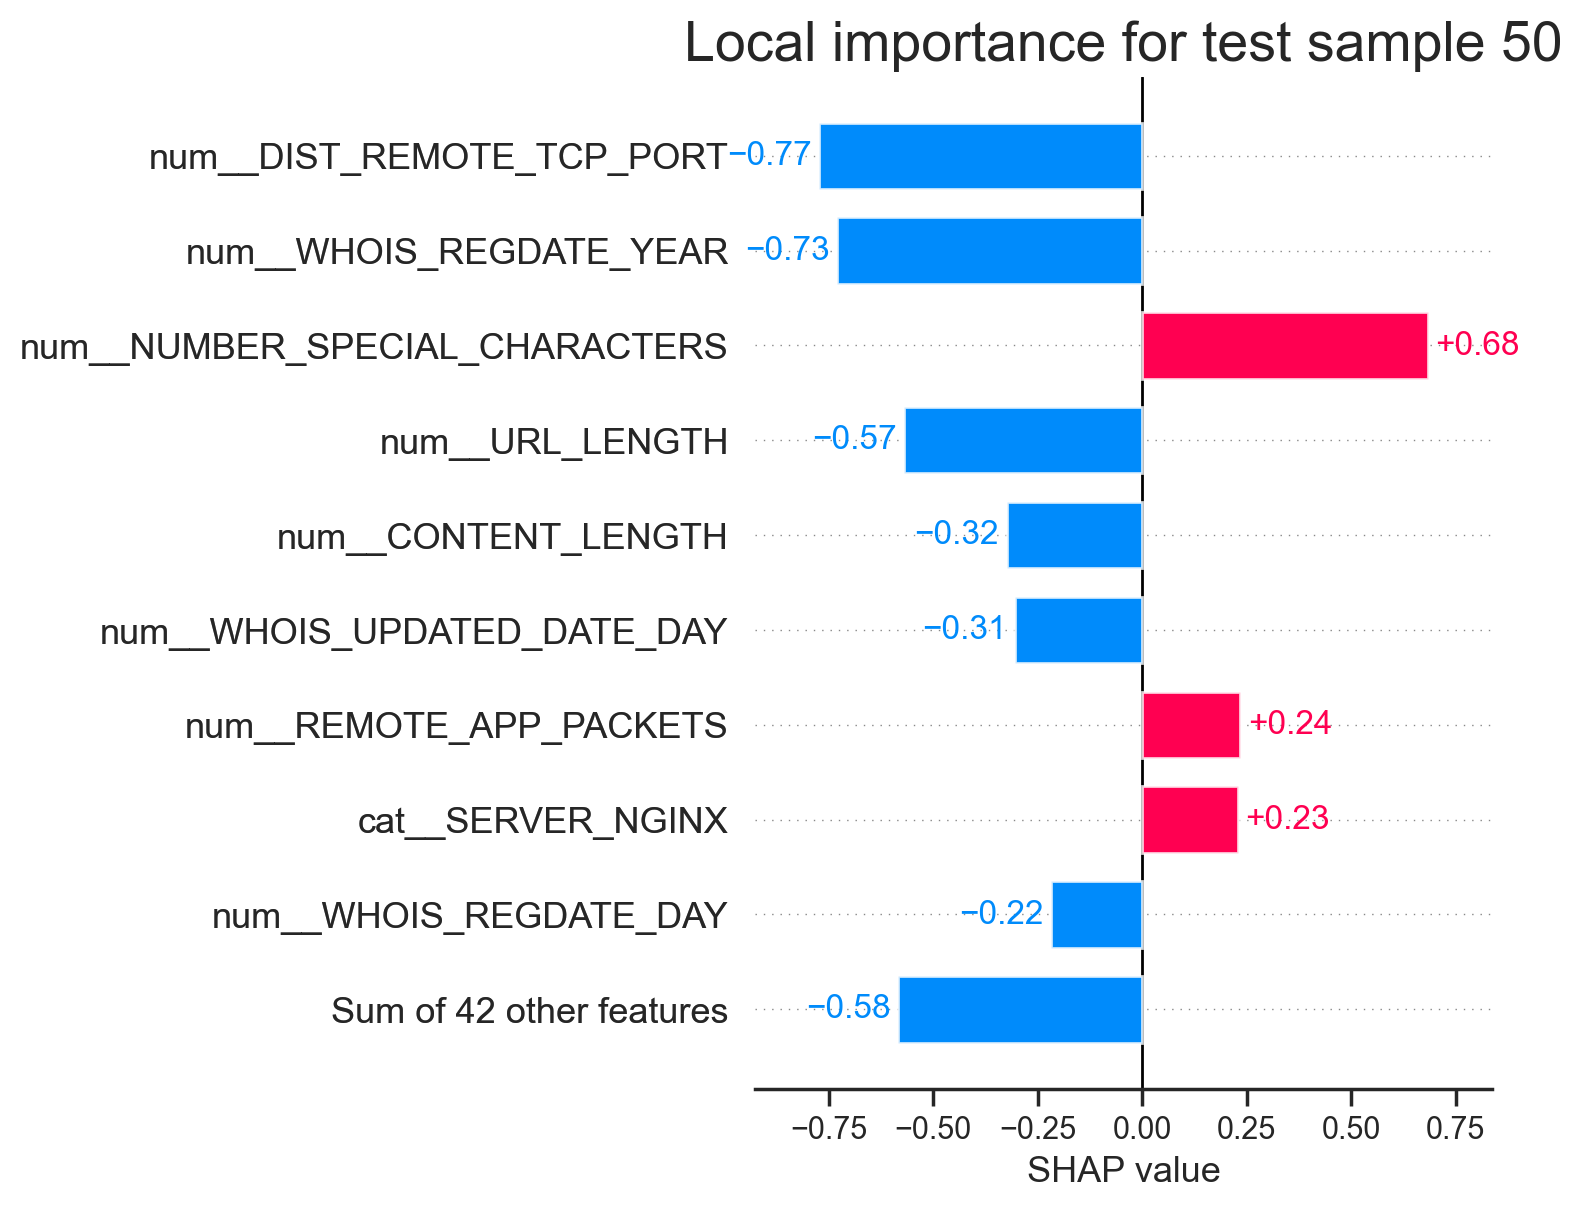

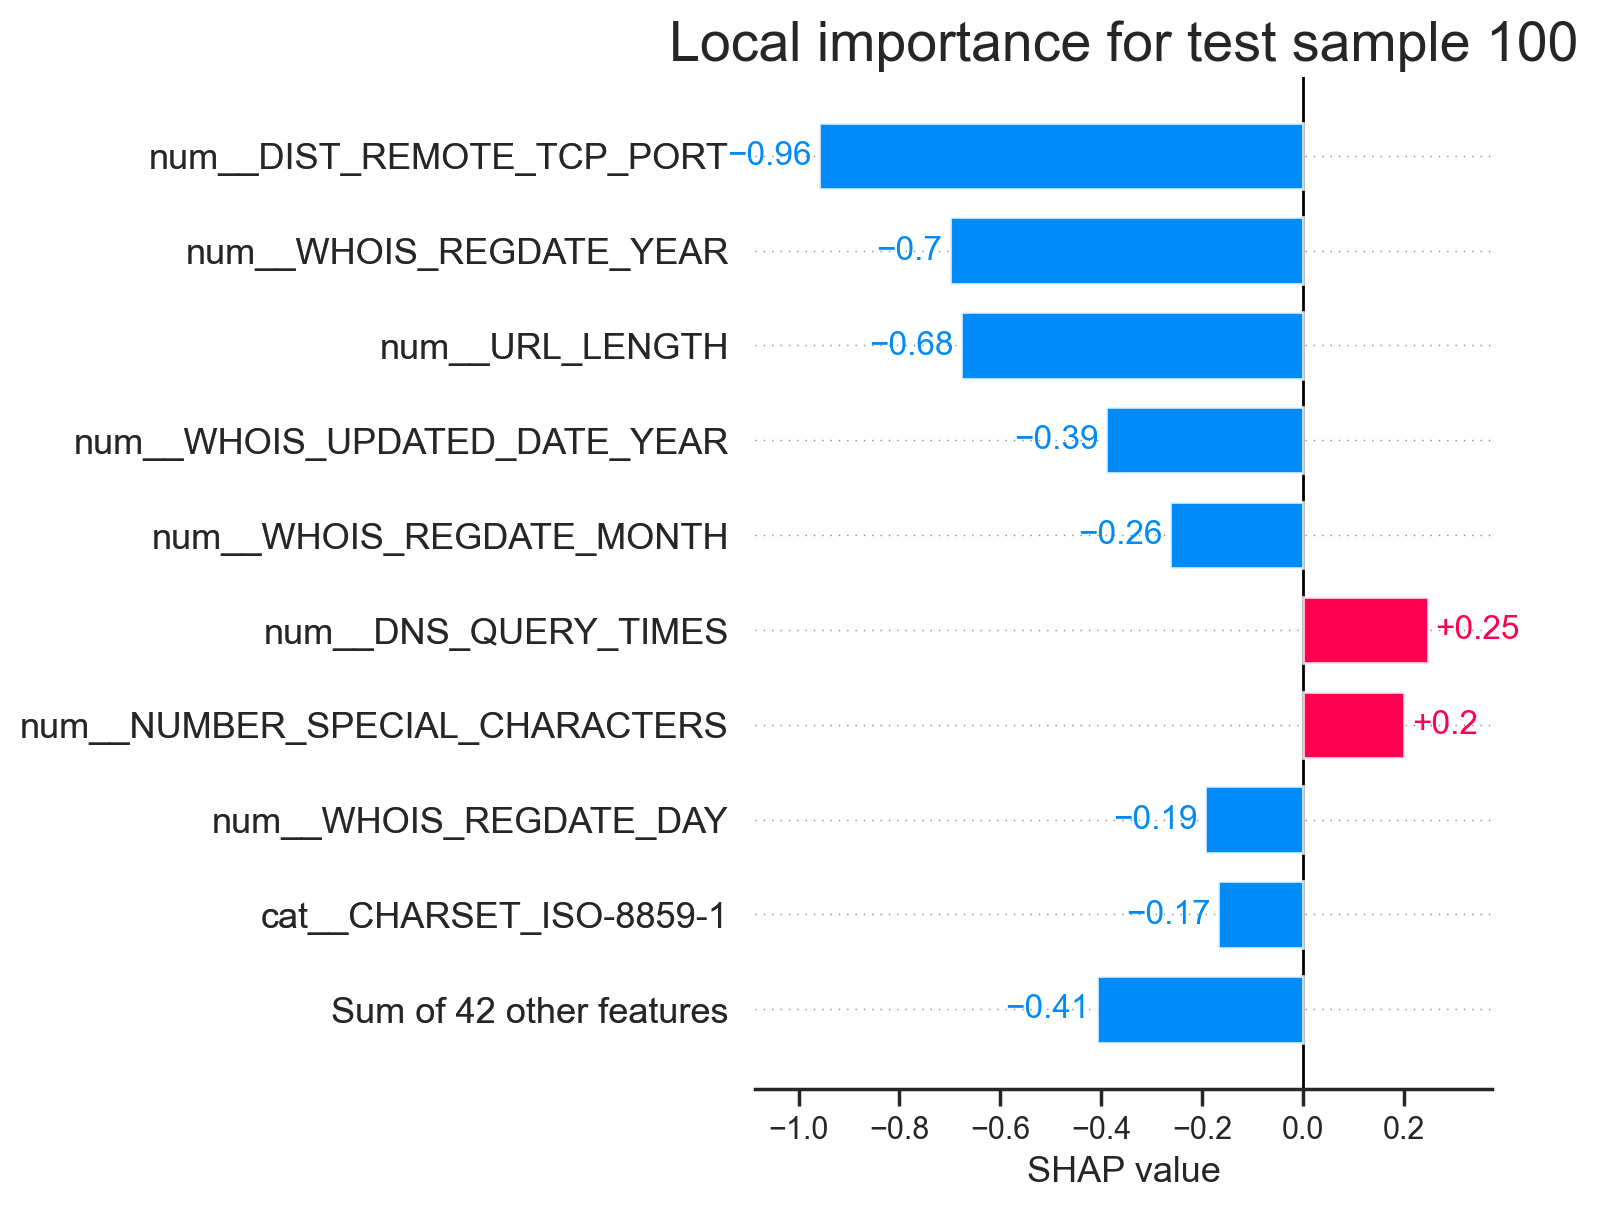

In [15]:
def plot_bar(idx, i):
    plt.figure(figsize=(18, 10))
    shap.plots.bar(shap_values[idx], show=False)
    plt.title(f'Local importance for test sample {idx}')
    plt.tight_layout()
    plt.savefig(f'../figures/SHAPBarPlot_{i}.png', dpi=400)
    plt.savefig(f'../figures/SHAPBarPlot_{i}.pdf', dpi=400)


plot_bar(20, 0)
plot_bar(50, 1)
plot_bar(100, 2)